# Проект: Обучение с учителем: качество модели

Я работаю в отделе цифровых технологий интернет-магазина «В один клик».\
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Ход исследования:** \
Шаг 1 - Загрузка и изучение общей информации; \
Шаг 2 - Предобработка данных; \
Шаг 3 - Исследовательский анализ данных; \
Шаг 4 - Объединение таблиц; \
Шаг 5 - Корреляционный анализ; \
Шаг 6 - Использование пайплайнов; \
Шаг 7 - Анализ важности признаков; \
Шаг 8 - Сегментация покупателей;\
Шаг 9 - Итоговый вывод. 

## Шаг 1. Загрузка данных

Загружаем библиотеки, которые понадобятся в нашем исследовании - (долго бился с установкой, локально всё работает - в HUB всё красным красно).  

In [1]:
!pip install -q scipy==1.12.0

In [2]:
!pip install -q numpy==1.26.4

In [3]:
!pip install -q shap

In [4]:
!pip install -q phik

In [5]:
!pip install -q matplotlib==3.8.4

In [6]:
!pip install -q pandas==2.2.2

In [7]:
!pip install -q seaborn==0.13.2

In [8]:
!pip install -q scikit-learn==1.5.0

In [9]:
# импоритруем pandas для обработки, анализа и структурирования данных
import pandas as pd 
# импоритруем numpy для работы с данными
import numpy as np 
# так же импоритруем matplotlib.pyplot для будущего построения графиков
import matplotlib.pyplot as plt 
# так же импоритруем seaborn для построения графиков
import seaborn as sns 

# импоритруем phik для построения матрицы корреляций Фи
import phik 
import shap
# Импортируем функцию для разделения датасета на выборки
from sklearn.model_selection import (
train_test_split,
GridSearchCV,
RandomizedSearchCV
)
# Импортируем классы для кодирования и масштабирования
from sklearn.preprocessing import (
OneHotEncoder,
StandardScaler, 
OrdinalEncoder, 
MinMaxScaler
)
# Подключаем модели логистической регрессии, KNN, SVC, DTC.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# Подключаем метрики F1, ROC_AUC и т.д.
from sklearn.metrics import (
roc_auc_score, 
f1_score, 
recall_score,
precision_score,
accuracy_score,
confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)

### 1.1 Загрузим данные из csv-файлов в датафреймы c помощью библиотеки pandas

In [10]:
try: # открываем наши файлы с данными в среде JupiterHUB:
    df_market_file = pd.read_csv('/datasets/market_file.csv') # представлена информация о о поведении покупателя на сайте, 
# о коммуникациях с покупателем и его продуктовом поведении.
    df_market_money = pd.read_csv('/datasets/market_money.csv') # хранит данные о выручке, которую получает магазин с покупателя, 
# то есть сколько покупатель всего потратил за период взаимодействия с сайтом..
    df_market_time = pd.read_csv('/datasets/market_time.csv') # это данные о о времени (в минутах), которое покупатель провёл 
# на сайте в течение периода.
    df_money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',') # таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: 
# какую прибыль получает магазин от продаж каждому покупателю.
except: # либо берем данные на ПК для локальной версии Jupiter:
    df_market_file = pd.read_csv('C://Users//Voova//datasets//market_file.csv') 
    df_market_money = pd.read_csv('C://Users//Voova//datasets//market_money.csv')
    df_market_time = pd.read_csv('C://Users//Voova//datasets//market_time.csv')
    df_money = pd.read_csv('C://Users//Voova//datasets//money.csv', sep = ';', decimal = ',')

### 1.2 Изучим общую информацию о датафреймах. Выведим первые строки наборов данных.

1.2.1 Посмотрим датафрейм `df_market_file`:

In [11]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Перед нами датафрейм на **13** колонок и **1300** строк. Пропущенные значения не обнаружены. \
Названия колонок выбиваются из привычных обозначений латинницей *(nazvanie_stolbsta)*, так как в данном случае кириллицу воспринимать удобнее. \
Отмечу, что на этапе предобработки, в названиях столбцов необходимо заменить нижнее подчеркивание на пробел. \
Посмотрим первые 5 строчек таблицы:

In [12]:
df_market_file.head(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Типы данных корректные, данные в таблице соответствуют описанию. Значение столбца `Тип сервиса` - `стандартт` неявно дублируется.

1.2.2 Посмотрим датафрейм `df_market_money`:

In [13]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Перед нами датафрейм на **3** колонки и **3900** строк. Пропущенные значения не обнаружены. \
Посмотрим первые 5 строчек таблицы:

In [14]:
df_market_money.head(5)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Типы данных корректные, данные в таблице соответствуют описанию.\
На этапе предобработки данных приведем значения в столбце `Период` к общему стилю с исправлением орфографических ошибок(неявных дубликатов).

1.2.3 Посмотрим датафрейм `df_market_time`:

In [15]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Перед нами датафрейм на **3** колонки и **2600** строк. Пропущенные значения не обнаружены.\
Посмотрим первые 5 строчек таблицы:

In [16]:
df_market_time.head(5)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Типы данных корректные, данные в таблице соответствуют описанию. \
На этапе предобработки данных приведем значения в столбце `Период` к общему стилю с исправлением орфографических ошибок(неявных дубликатов).

1.2.4 Посмотрим датафрейм `df_money`:

In [17]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Перед нами датафрейм из **2** колонок и **1300** строк. Пропущенные значения не обнаружены.\
Посмотрим первые 5 строчек таблицы:

In [18]:
df_money.head(5)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Типы данных корректные, данные в таблице соответствуют описанию.

### 1.3 Вывод:

В нашем распоряжении датафреймы:
- `df_market_file` на **13** колонок и **1300** строк;
- `df_market_money` на **3** колонки и **3900** строк;
- `df_market_time` на **3** колонки и **2600** строк;
- `df_money` на **2** колонки и **1300** строк.
Пропуски в данных не обнаружены.\
Для корректного исследования необходимо предобработать данные, а именно:
- привести названия столбцов к общему стилю;
- преобразовать значения в столбце `Период` к общему стилю;
- проверить датафреймы на явные/неявные дубликаты.

## Шаг 2. Предобработка данных

### 2.1 Приведем названия столбцов датафреймов к общему стилю

In [19]:
# в датафрейме df_market_file заменяем нижнее подчеркивание на пробел, а так же подредактируем некоторые столбцы для лучшего восприятия: 
df_market_file.columns = df_market_file.columns.str.replace('_', ' ')
df_market_file = df_market_file.rename(
    columns = {'Разрешить сообщать' : 'Разрешение сообщать',
               'Маркет актив 6 мес' : 'Маркетинговая активность, 6 мес',
               'Маркет актив тек мес' : 'Маркетинговая активность, текущий месяц',
               'Неоплаченные продукты штук квартал' : 'Неоплаченные продукты, шт/квартал'}
)

In [20]:
df_market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешение сообщать',
       'Маркетинговая активность, 6 мес',
       'Маркетинговая активность, текущий месяц', 'Длительность',
       'Акционные покупки', 'Популярная категория',
       'Средний просмотр категорий за визит',
       'Неоплаченные продукты, шт/квартал', 'Ошибка сервиса',
       'Страниц за визит'],
      dtype='object')

In [21]:
# в датафрейме df_market_time так же сделаем столбец "минуты" с заглавной буквы. 
df_market_time = df_market_time.rename(columns = {'минут' : 'Минут'})

In [22]:
df_market_time.columns

Index(['id', 'Период', 'Минут'], dtype='object')

### 2.2 Преобразуем значения в столбце `Период` датафреймов `df_market_time` и `df_market_money` к общему стилю

In [23]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Явная опечатка в значении, приведем к общему стилю:

In [24]:
df_market_time['Период'] = df_market_time['Период'].replace({'текущий_месяц':'Текущий месяц', 'предыдцщий_месяц':'Предыдущий месяц'})

In [25]:
df_market_time['Период'].unique()

array(['Текущий месяц', 'Предыдущий месяц'], dtype=object)

Посмотрим на значения столбца ['Период'] датасета `df_market_money`: 

In [26]:
df_market_money['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

Сразу стоит отметить, что **препредыдущий месяц** - это **НЕ** неявный дубликат, а значения позапрошлого месяца, т.к. нас интересует покупательская активность за последние 3 месяца (текущий, прошлый, позапрошлый). \
Приведем оформление к общему стилю:

In [27]:
df_market_money['Период'] = df_market_money['Период'].replace({'текущий_месяц':'Текущий месяц',
                                                               'предыдущий_месяц':'Предыдущий месяц',
                                                              'препредыдущий_месяц' : 'Позапрошлый месяц'})

In [28]:
df_market_money['Период'].unique()

array(['Позапрошлый месяц', 'Текущий месяц', 'Предыдущий месяц'],
      dtype=object)

### 2.3 Проверка на дубликаты:

2.3.1 Работаем с `df_market_file`

Проверим датасет на явные дубликаты: 

In [29]:
df_market_file.duplicated().sum() # выведим сумму явных дубикатов:

0

Явные дубликаты не обнаружены, сразу избавимся от ранее обнаруженного дубликата в столбце `Тип сервиса`: \
(и привдеем оформление к общему стилю)

In [30]:
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [31]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace({'премиум':'Премиум',
                                                               'стандартт':'Стандарт',
                                                              'стандарт' : 'Стандарт'})

Проверим на неявные дубликаты остальные столобцы с категориальными данными: 

In [32]:
df_market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

- Неявные дубликаты не обнаружены.

In [33]:
df_market_file['Популярная категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

- Неявные дубликаты не обнаружены.

In [34]:
df_market_file['Разрешение сообщать'].unique()

array(['да', 'нет'], dtype=object)

- Неявные дубликаты не обнаружены, однако приведем значения к общему стилю:

In [35]:
# если дальше по ходу проекта нам понадобится - преобразуем данный столбец в bool 
df_market_file['Разрешение сообщать'] = df_market_file['Разрешение сообщать'].replace({'да':'Да',
                                                               'нет':'Нет'})

In [36]:
#Проверяю количество неявных дубликатов по четырем столбцам:
df_market_file.duplicated(subset=['id', 'Покупательская активность', 'Тип сервиса', 'Популярная категория']).sum() 

0

- Неявные дубликаты не обнаружены.

Выведим 5 строк нашего преобразованного датасета:

In [37]:
df_market_file.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешение сообщать,"Маркетинговая активность, 6 мес","Маркетинговая активность, текущий месяц",Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,"Неоплаченные продукты, шт/квартал",Ошибка сервиса,Страниц за визит
1237,216585,Прежний уровень,Стандарт,Нет,5.9,3,134,0.25,Товары для детей,4,4,2,9
1283,216631,Прежний уровень,Стандарт,Да,3.0,3,455,0.24,Кухонная посуда,5,0,7,7
1072,216420,Прежний уровень,Стандарт,Да,6.3,4,606,0.25,Косметика и аксесуары,2,5,1,9
810,216158,Прежний уровень,Стандарт,Да,4.4,3,466,0.13,Товары для детей,3,4,2,6
366,215714,Снизилась,Стандарт,Да,3.8,5,694,0.40,Кухонная посуда,3,7,4,6


2.3.2 Работаем с `df_market_money`

In [38]:
df_market_money.duplicated().sum() # выведим сумму явных дубикатов:

0

- Явные дубликаты не обнаружены, так же в шаге 2.2 мы убедились, что неявные дубликаты тоже отсутствуют. 

2.3.3 Работаем с `df_market_time`

In [39]:
df_market_time.duplicated().sum() # выведим сумму явных дубикатов:

0

- Явные дубликаты не обнаружены, так же в шаге 2.2 мы убедились, что неявные дубликаты тоже отсутствуют.

2.3.4 Работаем с `df_money`

In [40]:
df_money.duplicated().sum() # выведим сумму явных дубикатов:

0

- Дубликаты отсутствуют. 

### Вывод: 
На этапе предобработки данных, мы:
- привели названия столбцов и содержимое датафреймов к общему стилю;
- устранили орфографическую ошибку в столбце `Период` датафрейма `df_market_time`;\
Провели проверку на явные/неявные дубликаты:
- устранили неявные дубликаты в столбце `Тип сервиса` датафрейма `df_market_file`, в остальных данных дубликаты отсутствуют. 

## Шаг 3. Исследовательский анализ данных: 

Проведем исследовательский анализ данных для каждой таблицы:

### 3.1 Исследуем `df_market_file`  
Сначала пройдем по количественным признакам и будем их рассматривать в контексте целевого признака - **покупательской активности**:
1. Маркетинговая активность, 6 мес
2. Маркетинговая активность, текущий месяц
3. Длительность
4. Акционные покупки
5. Средний просмотр категорий за визит
6. Неоплаченные продукты, шт/квартал
7. Ошибка сервиса
8. Страниц за визит

Далее посмотрим количественные признаки:\
9. Покупательская активность\
10. Тип сервиса\
11. Разрешение сообщать\
12. Популярная категория

1. Вызовем описательную функцию и построим гистограмму для *маркетинговой активности за 6 месяцев*:

In [41]:
df_market_file['Маркетинговая активность, 6 мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркетинговая активность, 6 мес, dtype: float64

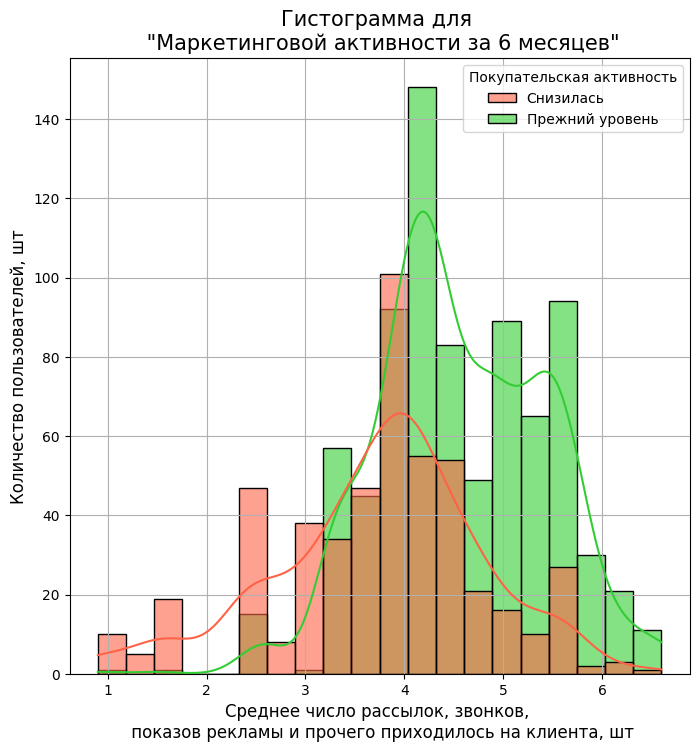

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 20, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Маркетинговая активность, 6 мес', 
             palette = palette, alpha = 0.6)
plt.title('Гистограмма для \n "Маркетинговой активности за 6 месяцев"', size = 15)
plt.xlabel('Среднее число рассылок, звонков, \n показов рекламы и прочего приходилось на клиента, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение похоже на нормальное, со сдвигом вправо, так же можно сказать, что покупательская активность пользователей с менее чем 4 рассылками - начала заметно снижаться. \
Для выявления выбросов построим Боксплот:

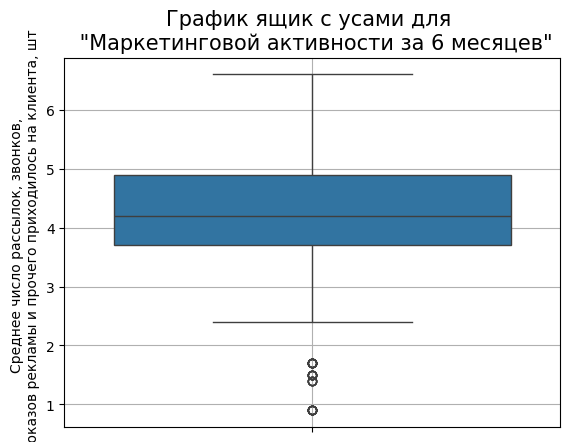

In [43]:
sns.boxplot(df_market_file['Маркетинговая активность, 6 мес'])
plt.title('График ящик с усами для \n "Маркетинговой активности за 6 месяцев"', size = 15)
plt.ylabel('Среднее число рассылок, звонков, \n показов рекламы и прочего приходилось на клиента, шт', size = 10)
plt.grid(True)
plt.show()

Число рассылок менее 2 будет считаться выбросами, посмотрим сколько у нас таких рассылок: 

In [44]:
len(df_market_file.query('`Маркетинговая активность, 6 мес` < 2'))

36

Предлагаю не удалять выбросы, так как в следующих шагах мы будем обучать 4 модели, в том числе **SVC** и **Decision Tree**, которые имеют меньшую чувствительность к выбросам.  

2. Вызовем описательную функцию и построим гистограмму для *маркетинговой активности за текущий месяц*:

In [45]:
df_market_file['Маркетинговая активность, текущий месяц'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркетинговая активность, текущий месяц, dtype: float64

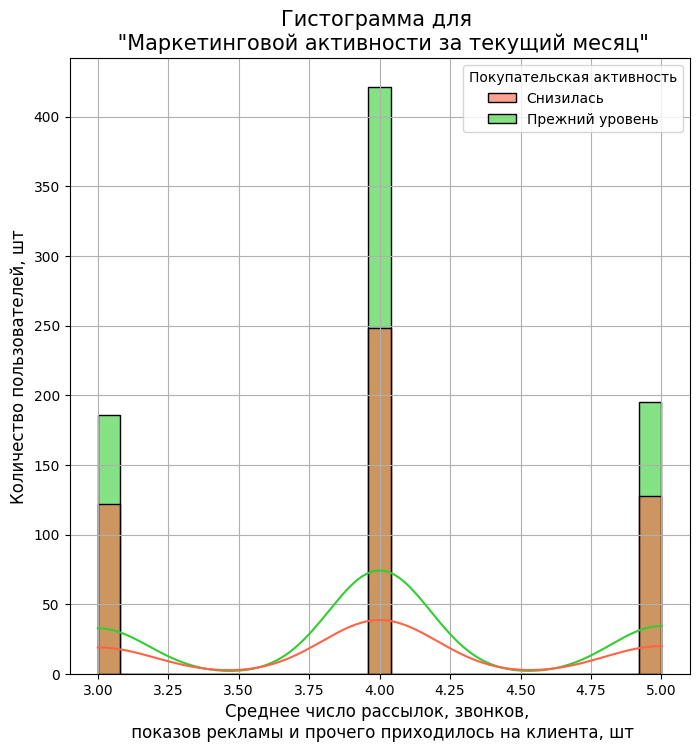

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Маркетинговая активность, текущий месяц',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма для \n "Маркетинговой активности за текущий месяц"', size = 15)
plt.xlabel('Среднее число рассылок, звонков, \n показов рекламы и прочего приходилось на клиента, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение имеет четкие границы и разделено на 3 сектора, так же отмечу, что покупательская активность большинства пользователей осталась на прежнем уровне.\
Для выявления выбросов построим Боксплот:

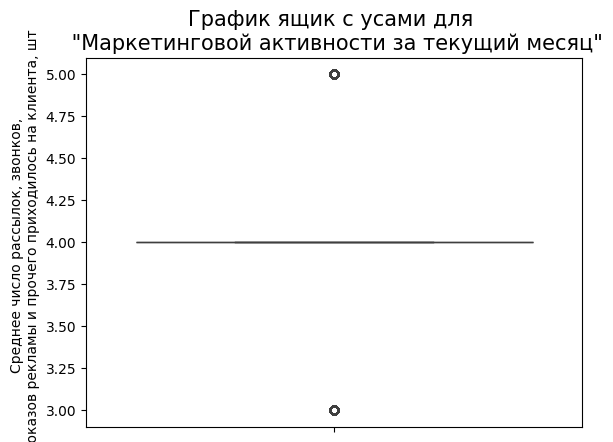

In [47]:
sns.boxplot(df_market_file['Маркетинговая активность, текущий месяц'])
plt.title('График ящик с усами для \n "Маркетинговой активности за текущий месяц"', size = 15)
plt.ylabel('Среднее число рассылок, звонков, \n показов рекламы и прочего приходилось на клиента, шт', size = 10)
plt.show()

Выбросы имеются, но аномально больших/маленьких значений не обнаружено. 

3. Вызовем описательную функцию и построим гистограмму для *Длительность (сколько дней прошло с момента регистрации покупателя на сайте)*:

In [48]:
df_market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

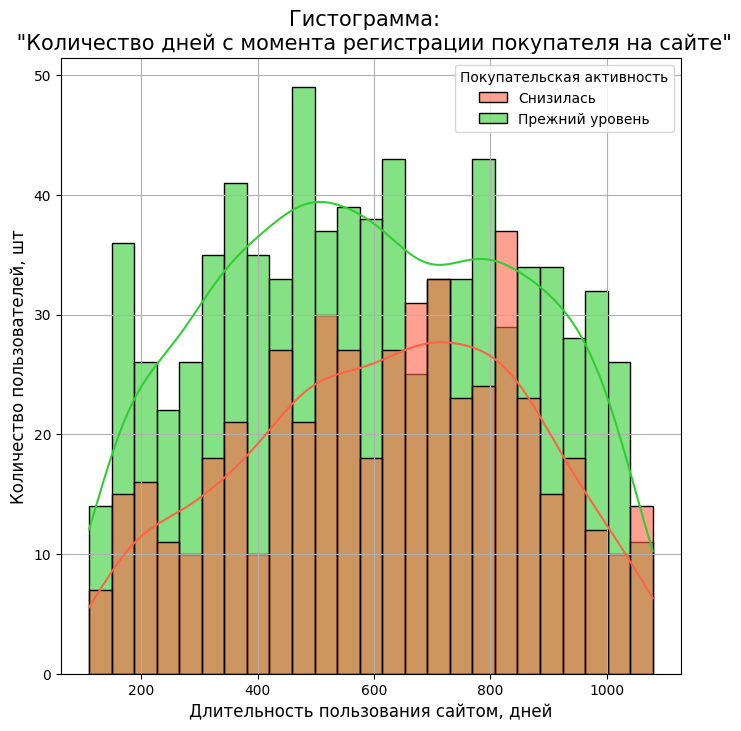

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Длительность',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Количество дней с момента регистрации покупателя на сайте"', size = 15)
plt.xlabel('Длительность пользования сайтом, дней', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Гистограмма больше похожа на плато, наличие снижения покупательской активности наблюдается среди всех пользователей - от ньюфагов до олдов. \
Для выявления выбросов построим Боксплот:

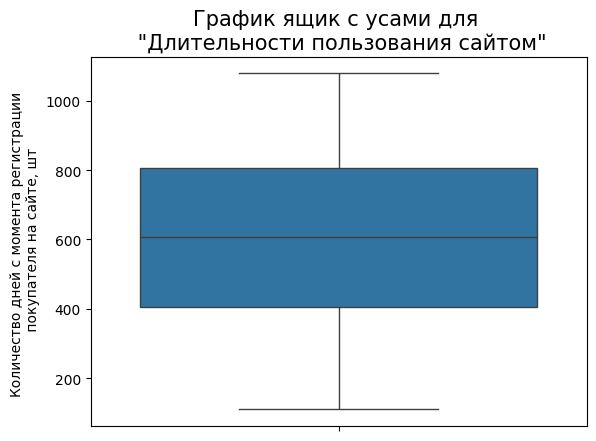

In [50]:
sns.boxplot(df_market_file['Длительность'])
plt.title('График ящик с усами для \n "Длительности пользования сайтом"', size = 15)
plt.ylabel('Количество дней с момента регистрации \n покупателя на сайте, шт', size = 10)
plt.show()

Выбросы не обнаружены. 

4. Вызовем описательную функцию и построим гистограмму для *Акционные покупки*:

In [51]:
df_market_file['Акционные покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные покупки, dtype: float64

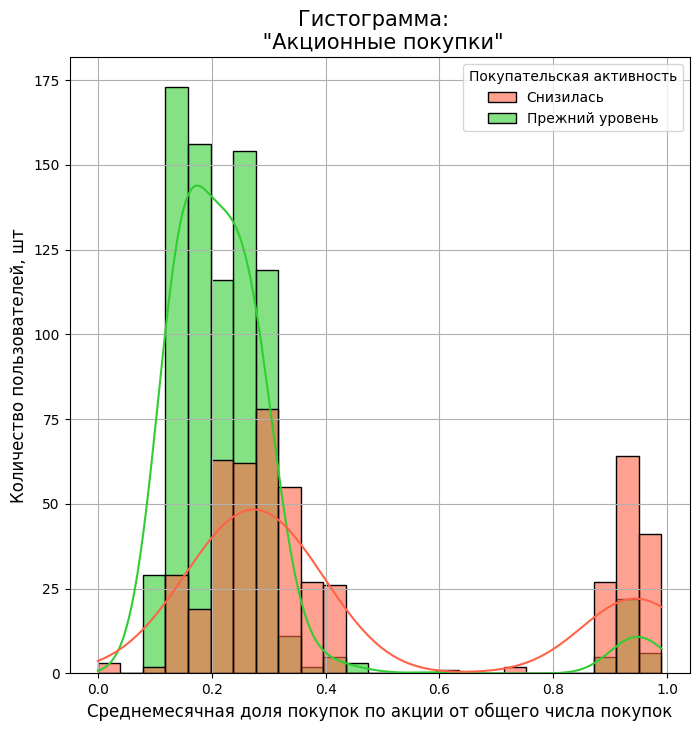

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Акционные покупки',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Акционные покупки"', size = 15)
plt.xlabel('Среднемесячная доля покупок по акции от общего числа покупок', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение похоже на бимодальное, что интересно - покупательская активность пользователей, которые почти всегда брали по акции (с долей 0,9-1,0), значительно снизилась - может быть в нашей компании закончились акции ? \
Для выявления выбросов построим Боксплот:

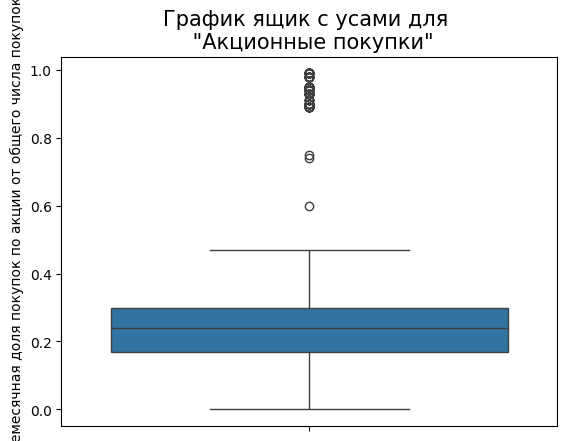

In [53]:
sns.boxplot(df_market_file['Акционные покупки'])
plt.title('График ящик с усами для \n "Акционные покупки"', size = 15)
plt.ylabel('Среднемесячная доля покупок по акции от общего числа покупок', size = 10)
plt.show()

In [54]:
# считаю количество выбросов
len(df_market_file.query('`Акционные покупки` > 0.6'))

167

167 выбросов - это почти 13% от нашего датасета, оставляем их на месте. 

5. Вызовем описательную функцию и построим гистограмму для *Средний просмотр категорий за визит*:

In [55]:
df_market_file['Средний просмотр категорий за визит'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний просмотр категорий за визит, dtype: float64

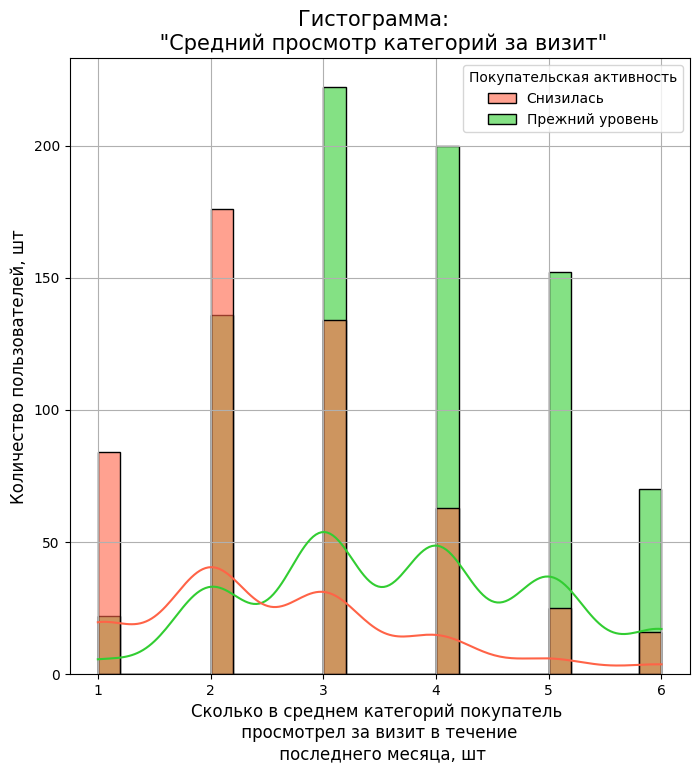

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Средний просмотр категорий за визит',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Средний просмотр категорий за визит"', size = 15)
plt.xlabel('Сколько в среднем категорий покупатель \n просмотрел за визит в течение \n последнего месяца, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение похоже на нормальное, отмечу, что с уменьшением количества просмотренных категорий товара - уменьшается покупателькая активность.\
Для выявления выбросов построим Боксплот:

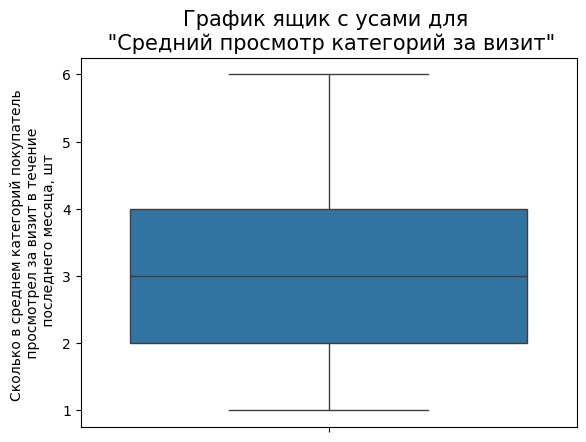

In [57]:
sns.boxplot(df_market_file['Средний просмотр категорий за визит'])
plt.title('График ящик с усами для \n "Средний просмотр категорий за визит"', size = 15)
plt.ylabel('Сколько в среднем категорий покупатель \n просмотрел за визит в течение \n последнего месяца, шт', size = 10)
plt.show()

Выбросы не обнаружены. 

6. Вызовем описательную функцию и построим гистограмму для *Неоплаченные продукты, шт/квартал*:

In [58]:
df_market_file['Неоплаченные продукты, шт/квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные продукты, шт/квартал, dtype: float64

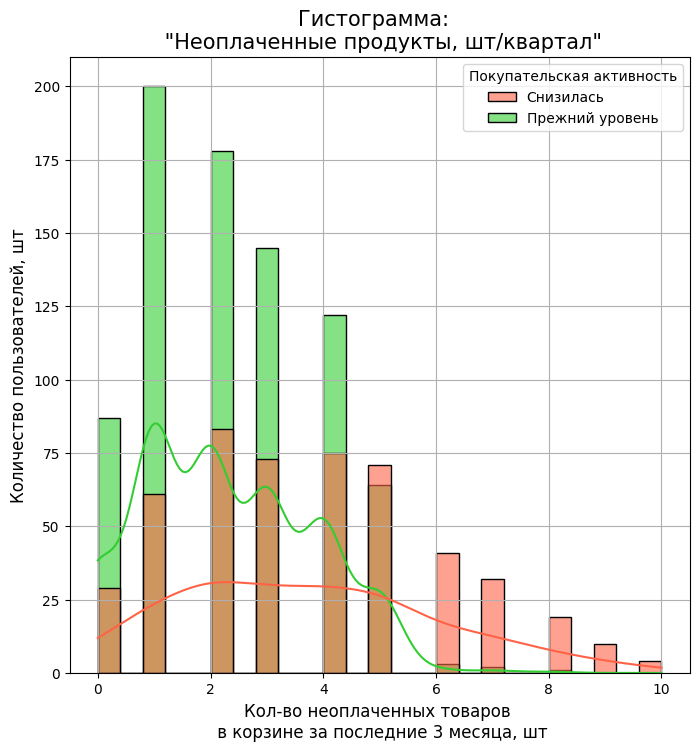

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Неоплаченные продукты, шт/квартал',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Неоплаченные продукты, шт/квартал"', size = 15)
plt.xlabel('Кол-во неоплаченных товаров \n в корзине за последние 3 месяца, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Гистограмма наглядно показывает тенденцию того, что чем больше неоплаченных товаров в корзине, тем меньше покупательская активность - что вполне логично.

7. Вызовем описательную функцию и построим гистограмму для *Ошибка сервиса*:

In [60]:
df_market_file['Ошибка сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка сервиса, dtype: float64

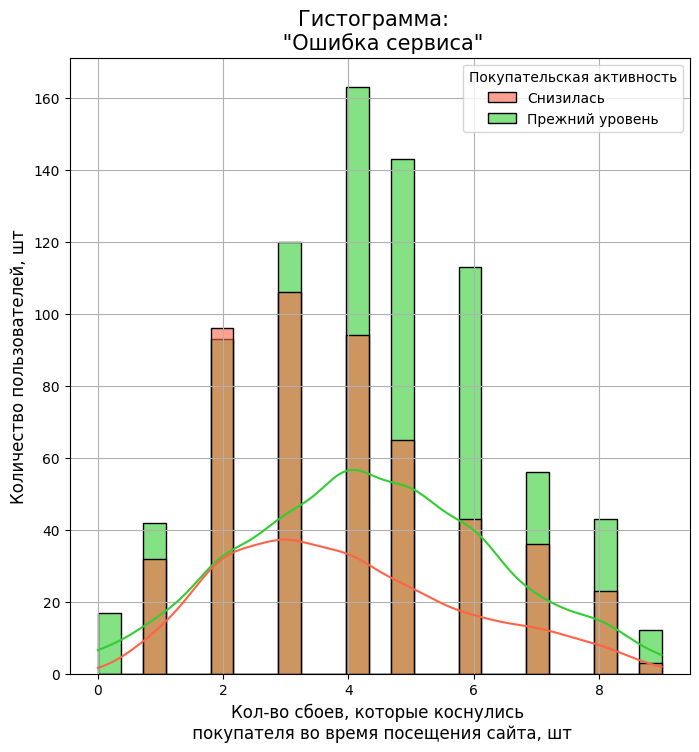

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 25, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Ошибка сервиса',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Ошибка сервиса"', size = 15)
plt.xlabel('Кол-во сбоев, которые коснулись \n покупателя во время посещения сайта, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение сбоев похоже на нормальное, отмечу, что снижение покупательской активности достигает максимума при количестве сбоев от 2 до 4. 

8. Вызовем описательную функцию и построим гистограмму для *Страниц за визит*:

In [62]:
df_market_file['Страниц за визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц за визит, dtype: float64

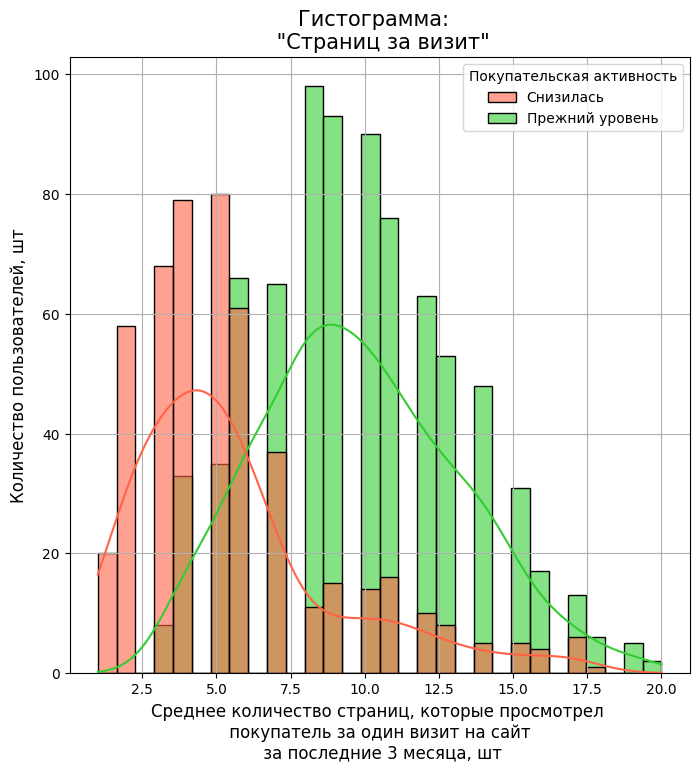

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 30, 
             kde = True, ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Страниц за визит',
             palette = palette, alpha = 0.6)
plt.title('Гистограмма:  \n "Страниц за визит"', size = 15)
plt.xlabel('Среднее количество страниц, которые просмотрел \n покупатель за один визит на сайт \n за последние 3 месяца, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение похоже на нормальное, наблюдается тенденция к снижению покупательской активности у пользователей, которые смотрят менее 7 страниц за один визит на сайт. \
Это может быть связано с тем, что пользователь перешел по рекламной ссылке или он не заинтересован в товаре, тогда как большее посещение страниц, говорит о том, что пользователи выбирают товар тщательно - из предложенных вариантов в магазине, может быть сравнивая товары между собой.  

9. Построим круговую диаграмму для *Покупательской активности*:

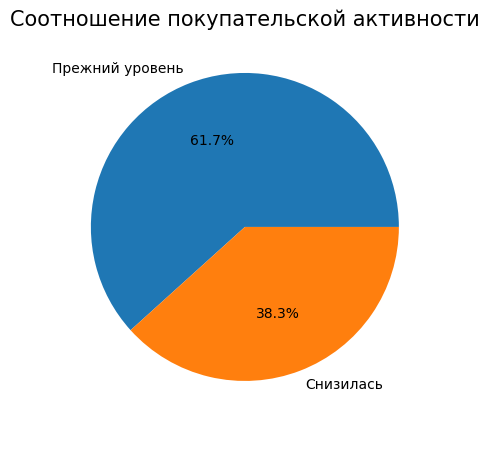

In [64]:
(
    df_market_file
    .groupby('Покупательская активность')['id']
    .count()
    .plot(kind='pie', figsize=(5, 5), autopct='%1.1f%%')
)
plt.xticks(rotation=45)
plt.title('Соотношение покупательской активности', size=15)
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

Как видно из диаграммы выше, покупательская активность снижена в 38,3 % случаев. 

10. Построим диаграмму для *Типа сервиса*:

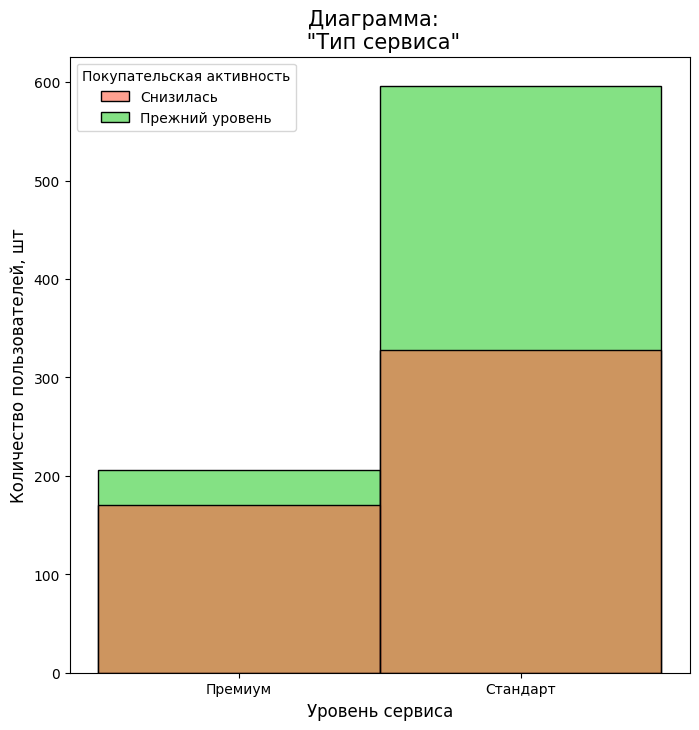

In [65]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 30, 
             ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Тип сервиса',
             palette = palette, alpha = 0.6)
plt.title('Диаграмма:  \n "Тип сервиса"', size = 15)
plt.xlabel('Уровень сервиса', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.show()

Как видно из диаграммы выше - большинство пользователей пользуются стандартным тарифом, однако в долевом соотношении - покупательская активность `снизилась больше у премиум пользователей`. 

11. Построим диаграмму для  столбца *Разрешение сообщать*:

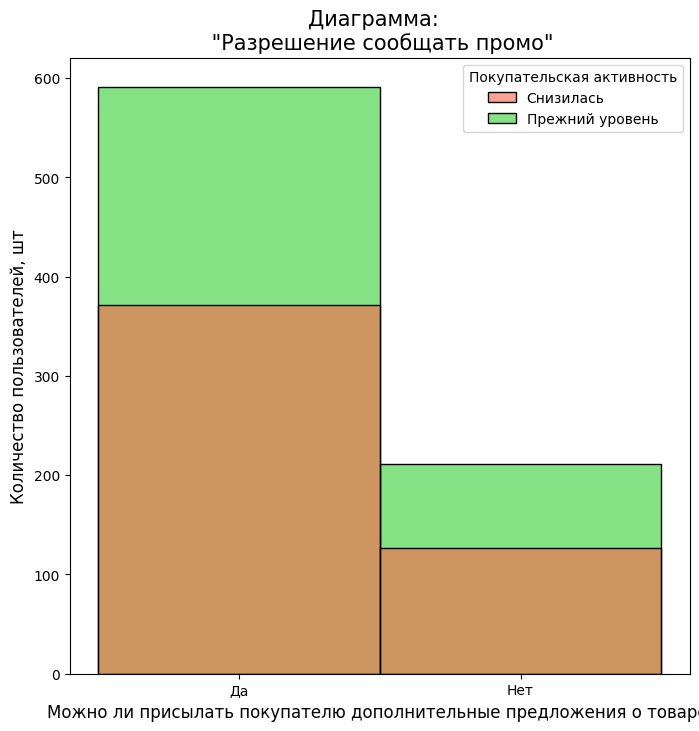

In [66]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 30, 
             ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Разрешение сообщать',
             palette = palette, alpha = 0.6)
plt.title('Диаграмма:  \n "Разрешение сообщать промо"', size = 15)
plt.xlabel('Можно ли присылать покупателю дополнительные предложения о товаре.', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.show()

Большинство пользователей согласны получать дополнительные предложения о товарах, однако именно у таких пользователей и наблюдается большее снижение покупательской активности.

12. Построим диаграмму для столбца *Популярная категория*:

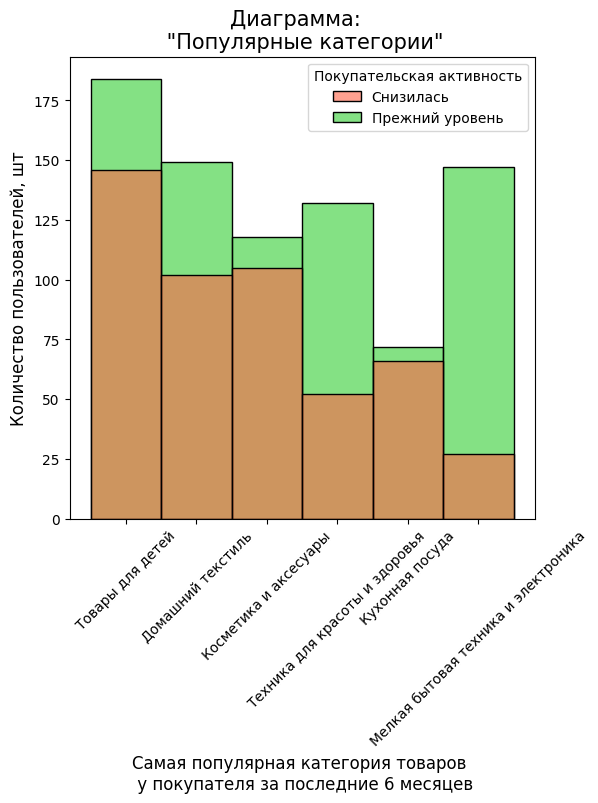

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
palette = {'Прежний уровень': 'limegreen', 'Снизилась': 'tomato'}
sns.histplot(df_market_file, bins = 30, 
             ax=ax, 
             hue = 'Покупательская активность', 
             x = 'Популярная категория',
             palette = palette, alpha = 0.6)
plt.title('Диаграмма:  \n "Популярные категории"', size = 15)
plt.xticks(rotation=45)
plt.xlabel('Самая популярная категория товаров \n у покупателя за последние 6 месяцев', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.show()

Наибольшей популярностью пользуются товары для детей, в то время как кухонная посуда занимает последнее место.\
Замечу, что в разделе бытовой техники покупательская позиция минимально потеряла свои позиции. 

 Покупательская активность
10. Тип сервиса
11. Разрешение сообщать
12. Популярная категория

### Промежуточный вывод:
1. Распределение `маркетинговой активности за 6 месяцев` похоже на нормальное, со сдвигом вправо, так же можно сказать, что покупательская активность пользователей с менее чем 4 рассылками - начала заметно снижаться.
2. Распределение `маркетинговой активности за текущий месяц` имеет четкие границы и разделено на 3 сектора, так же отмечу, что покупательская активность большинства пользователей осталась на прежнем уровне.
3. Гистограмма `длительности` больше похожа на плато, наличие снижения покупательской активности наблюдается среди всех пользователей - от ньюфагов до олдов.
4. Распределение `акционных покупок` похоже на бимодальное, что интересно - покупательская активность пользователей, которые почти всегда брали по акции (с долей 0,9-1,0), значительно снизилась.
5. Распределение `среднего просмотра категорий за визит` похоже на нормальное, отмечу, что с уменьшением количества просмотренных категорий товара - уменьшается покупателькая активность.
6. Гистограмма `неоплаченных продуктов` наглядно показывает тенденцию того, что чем больше неоплаченных товаров в корзине, тем меньше покупательская активность - что вполне логично.
7. Распределение `сбоев сервиса` похоже на нормальное, отмечу, что снижение покупательской активности достигает максимума при количестве сбоев от 2 до 4.
8. Распределение `страниц за визит` похоже на нормальное, наблюдается тенденция к снижению покупательской активности у пользователей, которые смотрят менее 7 страниц за один визит на сайт.\
Это может быть связано с тем, что пользователь перешел по рекламной ссылке или он не заинтересован в товаре, тогда как большее посещение страниц, говорит о том, что пользователи выбирают товар тщательно - из предложенных вариантов в магазине, может быть сравнивая товары между собой.
9. `Покупательская активность` снижена в 38,3 % случаев.
10. Большинство пользователей пользуются *стандартным тарифом*, однако в долевом соотношении - покупательская активность снизилась больше у премиум пользователей
11. Большинство пользователей `согласны` получать *дополнительные предложения* о товарах, однако именно у таких пользователей и наблюдается большее снижение покупательской активности.
12. Наибольшей популярностью пользуются товары для детей, в то время как кухонная посуда занимает последнее место.

### 3.2 Исследуем `df_market_money`

Построим диаграмму для столбца *Период*:

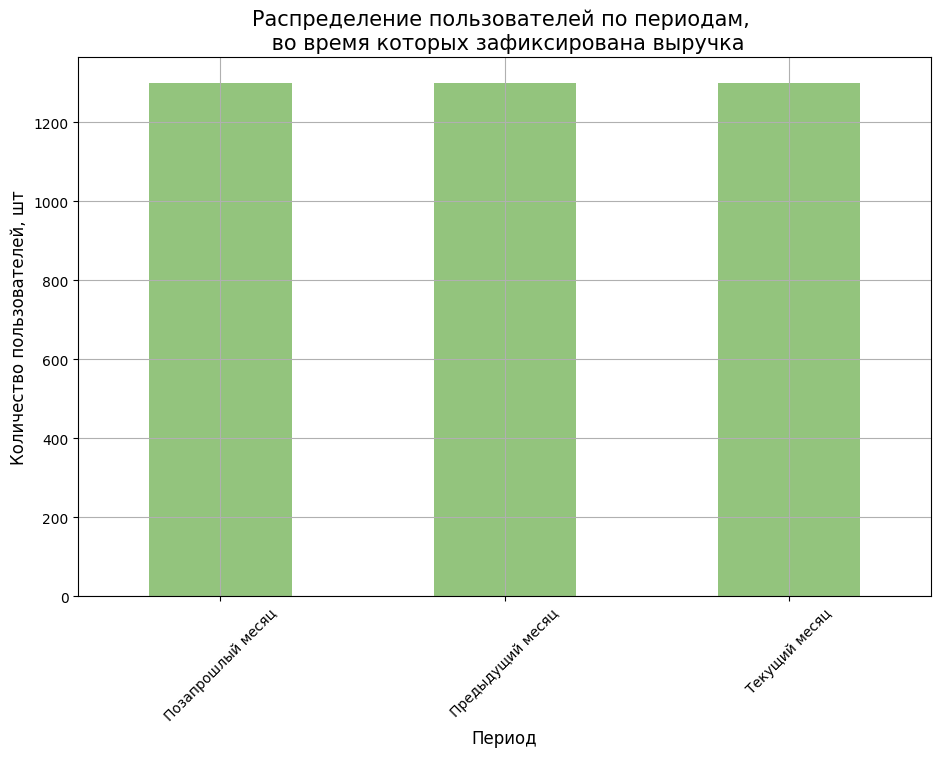

In [68]:
( # построим диаграмму методом .plot()
    df_market_money
    .groupby('Период')['id']
    .count()
    .sort_values(ascending = False)
    .plot(kind = 'bar', figsize = (11, 7), color = '#93c47d')
)
plt.xticks(rotation = 45)
plt.title('Распределение пользователей по периодам, \n во время которых зафиксирована выручка', size = 15)
plt.xlabel('Период', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

- Пользователи в таблице распределены равномерно, по 1300 значений из каждого периода. 

Вызовем описательную функцию и построим гистограмму для столбца *Выручка*:

In [69]:
df_market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

Минимальное значение выручки является 0, что идет вразрез со стратегией нашей компании - `удерживать активных и постоянных клиентов`, а вот максимальное значение выручки является аномально большим, посмотрим на гистограмме есть ли ещё такие значения:

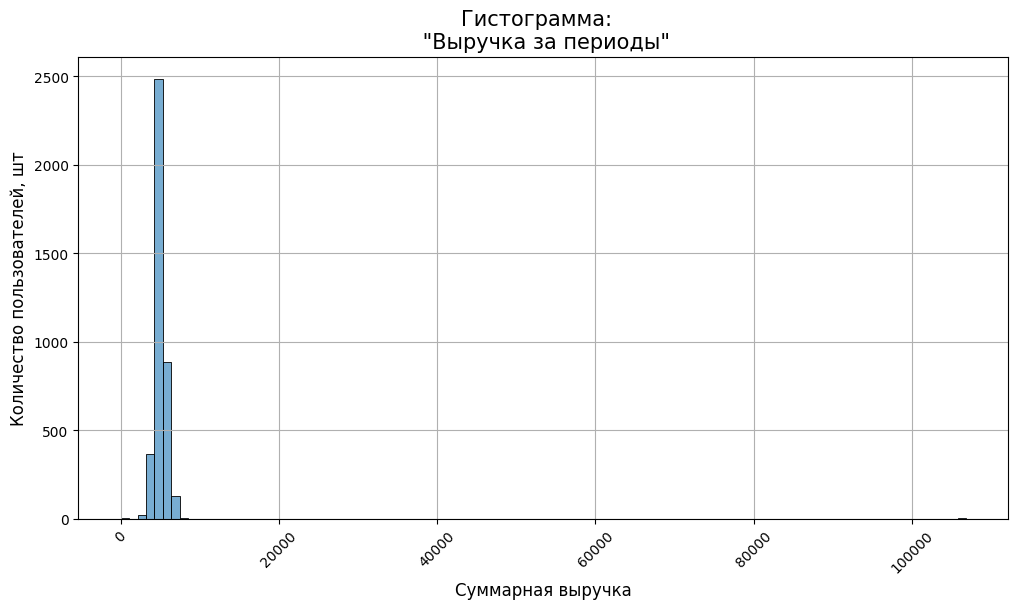

In [70]:
plt.figure(figsize=(12,6))
sns.histplot(df_market_money, bins = 100,  
             x = 'Выручка',
             alpha = 0.6)
plt.title('Гистограмма:  \n "Выручка за периоды"', size = 15)
plt.xticks(rotation = 45)
plt.xlabel('Суммарная выручка', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Удалим аномальное и нулевое значения и построим гистограмму заново: 

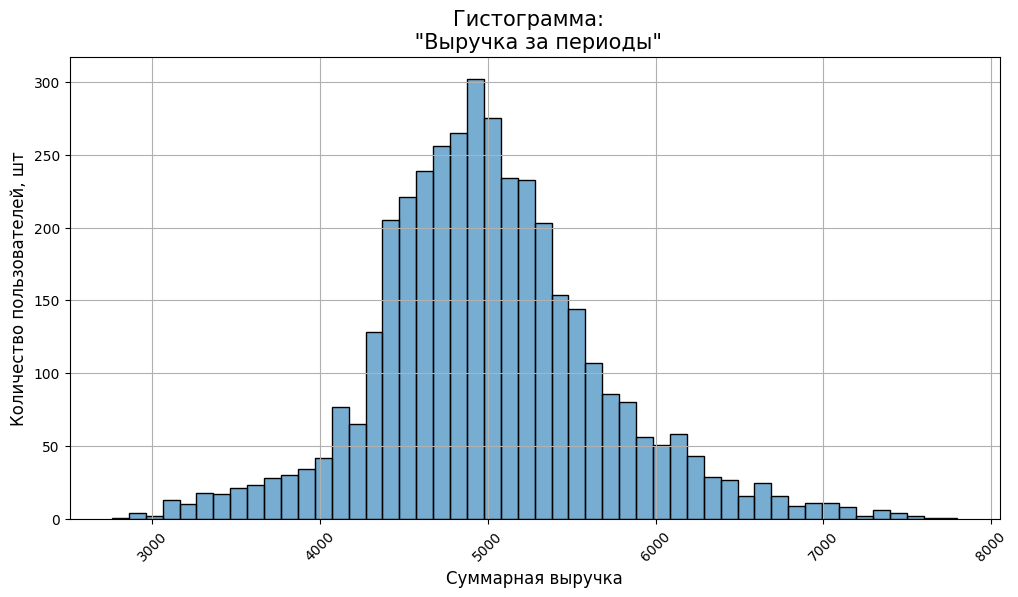

In [71]:
df_market_money = df_market_money[(df_market_money['Выручка'] > 0) & (df_market_money['Выручка']< 100000)]

plt.figure(figsize=(12,6))
sns.histplot(df_market_money, bins = 50,  
             x = 'Выручка',
             alpha = 0.6)
plt.title('Гистограмма:  \n "Выручка за периоды"', size = 15)
plt.xticks(rotation = 45)
plt.xlabel('Суммарная выручка', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение суммарной выручки похоже на нормальное, в среднем пользователи приносят по 5000 рублей. 

- Отберем клиентов с покупательской активностью не менее **трёх месяцев**, то есть таких, которые что-либо покупали в этот период.

In [72]:
# сгруппируем пользователей с нужной нам покупальский активностью: 
aktiv_users = df_market_money.pivot_table(index = 'id', values = 'Период', aggfunc = 'count')
aktiv_users = aktiv_users.query('Период == 3')
aktiv_users.head(5)

,Период
id,
215349,3
215350,3
215351,3
215352,3
215353,3


Теперь оставим в датафрейме `df_market_file` только активных пользователей:

In [73]:
df_market_file = df_market_file[df_market_file['id'].isin(aktiv_users.index)]
len(df_market_file)

1296

Четыре пользователя не прошли наш отбор. 

### Промежуточный вывод:
При изучении суммарной выручки были обнаружены и удалены пользователи с нулевой выручкой, т.к. они не интересны нашей компании, а так же удалено аномально высокое значение выручки. Распределение выручки характеризуется *нормальным* типом. \
Так же отбраны 1296 клиентов с покупательской активностью не менее трёх месяцев.

### 3.3 Исследуем `df_market_time`

Построим диаграмму для столбца Период:

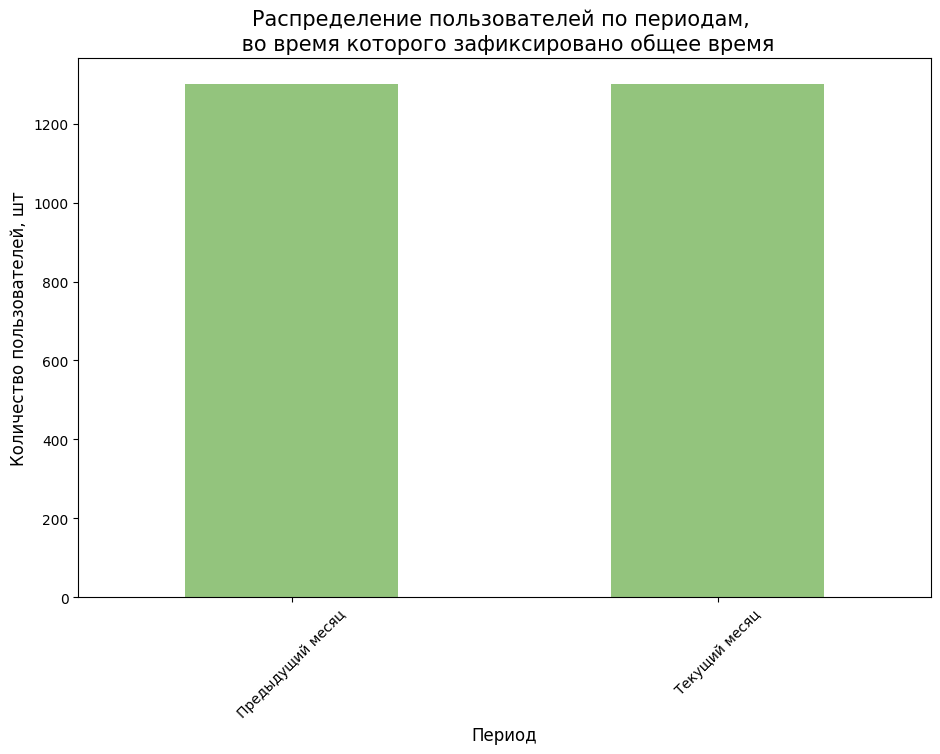

In [74]:
( # построим диаграмму методом .plot()
    df_market_time
    .groupby('Период')['id']
    .count()
    .sort_values(ascending = False)
    .plot(kind = 'bar', figsize = (11, 7), color = '#93c47d')
)
plt.xticks(rotation=45)
plt.title('Распределение пользователей по периодам, \n во время которого зафиксировано общее время', size=15)
plt.xlabel('Период', size=12)
plt.ylabel('Количество пользователей, шт', size=12)
plt.show()

Периоды по месяцам распределены равномерно. 

Вызовем описательную функцию и построим гистограмму для столбца *Минут*:

In [75]:
df_market_time['Минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: Минут, dtype: float64

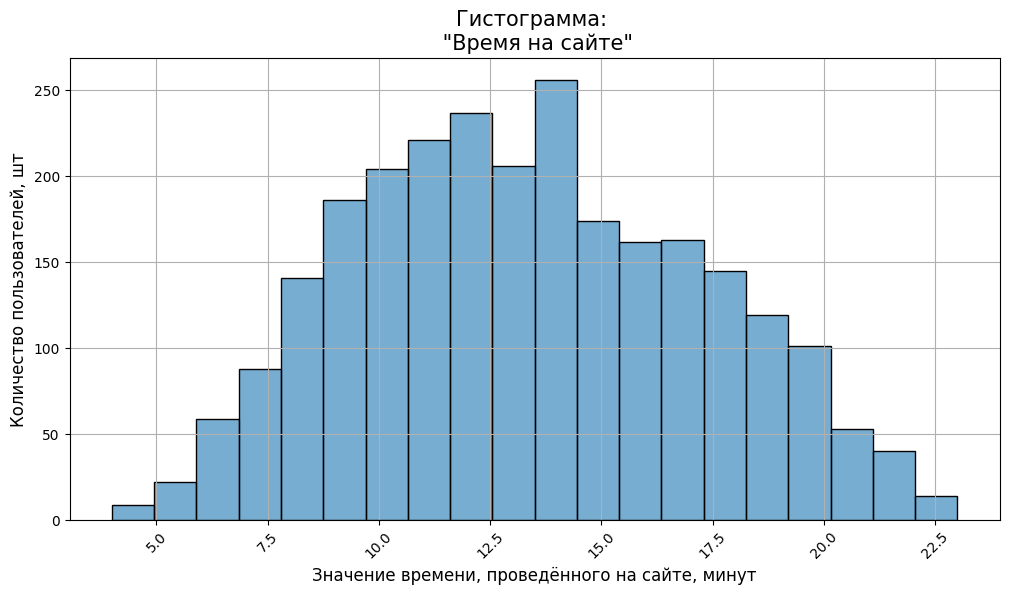

In [76]:
plt.figure(figsize=(12,6))
sns.histplot(df_market_time, bins = 20,  
             x = 'Минут',
             alpha = 0.6)
plt.title('Гистограмма: \n "Время на сайте"', size = 15)
plt.xticks(rotation = 45)
plt.xlabel('Значение времени, проведённого на сайте, минут', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Распределение времени, проведенное на сайте - характеризуется нормальным типом, в среднем пользователи находятся на сайте по 13 минут.  

### Промежуточный вывод:
Периоды, во время которых зафиксировано общее время распределены равномерно.\
Время, проведенное на сайте - характеризуется нормальным распределением и в среднем занимает 13 минут. 

### 3.4 Исследуем `df_money`

Вызовем описательную функцию и построим гистограмму для столбца *Прибыль*:

In [77]:
df_money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

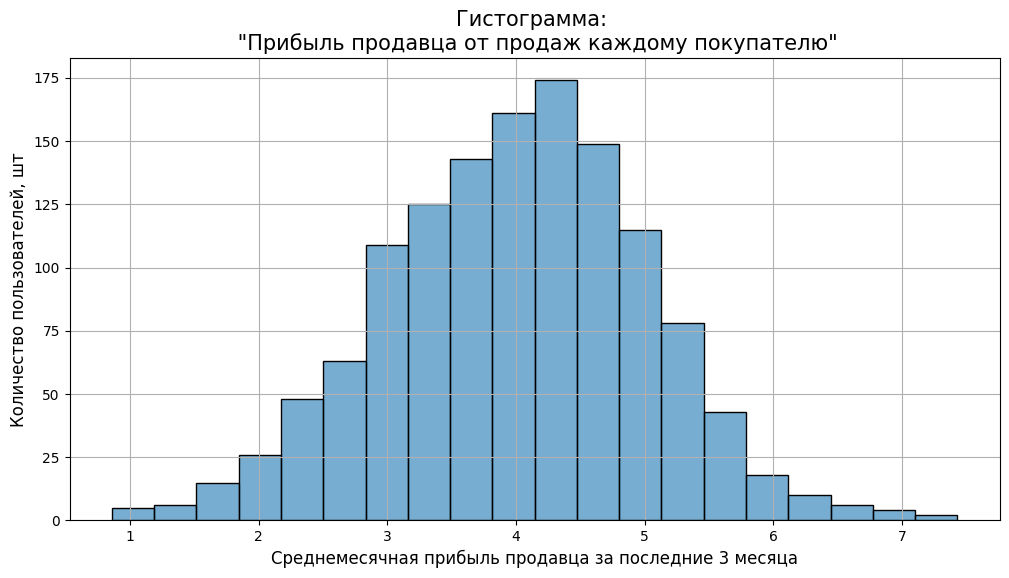

In [78]:
plt.figure(figsize=(12,6))
sns.histplot(df_money, bins = 20,  
             x = 'Прибыль',
             alpha = 0.6)
plt.title('Гистограмма: \n "Прибыль продавца от продаж каждому покупателю"', size = 15)
plt.xlabel('Среднемесячная прибыль продавца за последние 3 месяца', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Прибыль продавца от продаж каждому покупателю - характеризуется нормальным распределением и в среднем составляет 4 условные единицы. 

### ВЫВОД по разделу:
На этапе исследовательского анализа данных мы выяснили: 
1. `Покупательская активность` снижена в 38,3 % случаев.

2. Большинство пользователей пользуются *стандартным тарифом*, однако в долевом соотношении - покупательская активность снизилась больше у премиум пользователей
3. Большинство пользователей `согласны` получать *дополнительные предложения* о товарах, однако именно у таких пользователей и наблюдается большее снижение покупательской активности.
4. Наибольшей популярностью пользуются товары для детей, в то время как кухонная посуда занимает последнее место.

- При изучении суммарной выручки были обнаружены и удалены пользователи с нулевой выручкой, т.к. они не интересны нашей компании, а так же удалено аномально высокое значение выручки. Распределение выручки характеризуется *нормальным* типом. \
Так же отбраны 1296 клиентов с покупательской активностью не менее трёх месяцев.

- Время, проведенное на сайте - характеризуется нормальным распределением и в среднем занимает 13 минут.

- Прибыль продавца от продаж каждому покупателю - характеризуется нормальным распределением и в среднем составляет 4 условные единицы.

### Шаг 4. Объединение таблиц

Объединим данные из датафреймов `df_market_file`, `df_market_money` и `df_market_time` в одну таблицу.\
Данные о выручке и времени на сайте находятся в одном столбце для всех периодов.\
В итоговой таблице сделаем отдельный столбец для каждого периода:

In [79]:
# Сразу как в предыдущем шаге отфильтруем пользователей с нужной покупательской активностью в оставшихся таблицах: 
df_market_money = df_market_money[df_market_money['id'].isin(aktiv_users.index)]
df_market_time = df_market_time[df_market_time['id'].isin(aktiv_users.index)]

Сгруппируем `df_market_money` по выручке за разные периоды: 

In [80]:
df_market_money_new = df_market_money.pivot_table(index = ['id'], columns = "Период")
df_market_money_new.columns = ['Выручка за позапрошлый месяц', 'Выручка за предыдущий месяц', 'Выручка за текущий месяц']
df_market_money_new.head(5)

,Выручка за позапрошлый месяц,Выручка за предыдущий месяц,Выручка за текущий месяц
id,,,
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5
215353,5124.0,4738.5,5388.5


Сгруппируем `df_market_time` по времени за разные периоды:

In [81]:
df_market_time_new = df_market_time.pivot_table(index = ['id'], columns = "Период")
df_market_time_new.columns = ['Минут в предыдущий месяц', 'Минут в текущий месяц']
df_market_time_new.head(5)

,Минут в предыдущий месяц,Минут в текущий месяц
id,,
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0
215353,10.0,10.0


Приступаем к объединению получившихся таблиц:

In [82]:
df_market_full = df_market_file.merge(df_market_money_new, on = 'id').merge(df_market_time_new, on ='id')
df_market_full.head(5)

,id,Покупательская активность,Тип сервиса,Разрешение сообщать,"Маркетинговая активность, 6 мес","Маркетинговая активность, текущий месяц",Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,"Неоплаченные продукты, шт/квартал",Ошибка сервиса,Страниц за визит,Выручка за позапрошлый месяц,Выручка за предыдущий месяц,Выручка за текущий месяц,Минут в предыдущий месяц,Минут в текущий месяц
0,215349,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0
1,215350,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0
2,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0
3,215352,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0
4,215353,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10.0,10.0


In [83]:
df_market_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       1296 non-null   int64  
 1   Покупательская активность                1296 non-null   object 
 2   Тип сервиса                              1296 non-null   object 
 3   Разрешение сообщать                      1296 non-null   object 
 4   Маркетинговая активность, 6 мес          1296 non-null   float64
 5   Маркетинговая активность, текущий месяц  1296 non-null   int64  
 6   Длительность                             1296 non-null   int64  
 7   Акционные покупки                        1296 non-null   float64
 8   Популярная категория                     1296 non-null   object 
 9   Средний просмотр категорий за визит      1296 non-null   int64  
 10  Неоплаченные продукты, шт/квартал        1296 no

### ВЫВОД по разделу:
Данные из датафреймов `df_market_file`, `df_market_money` и `df_market_time` объединены в одну таблицу.\
Перед этим выполнено разделение времени и выручки по перодам. \
В итоговом датасете получили **18** столбцов и **1296** ненулевых строк. 

### Шаг 5. Корреляционный анализ

Для корреляционного анализа будем использовать матрицу корреляций $\phi$, так как она хорошо улавливает взаимосвязи между количественными и категориальными значениями. 

In [84]:
# берем нашу полную таблицу, за исключением столбца ['id']
df_ferma_phik = df_market_full.drop('id', axis = 1)

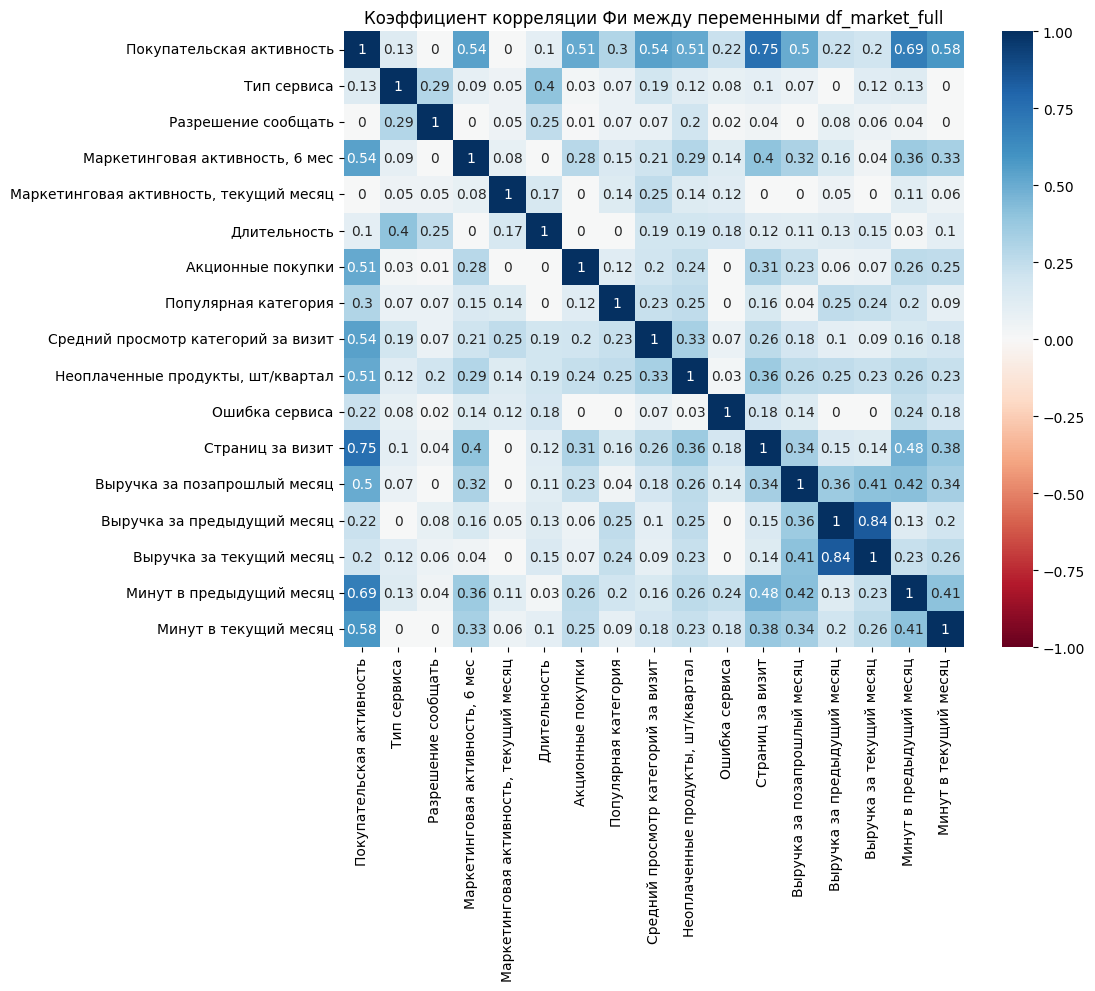

In [85]:
# Вычисляем матрицу корелляций Фи
phi_corr = df_ferma_phik.phik_matrix(interval_cols = ['Маркетинговая активность, 6 мес', 'Маркетинговая активность, текущий месяц',
                                                      'Длительность', 'Акционные покупки',
                                                      'Средний просмотр категорий за визит', 'Неоплаченные продукты, шт/квартал',
                                                      'Ошибка сервиса', 'Страниц за визит',
                                                      'Выручка за позапрошлый месяц', 'Выручка за предыдущий месяц',
                                                      'Выручка за текущий месяц', 'Минут в предыдущий месяц',
                                                      'Минут в текущий месяц']).round(2)

# Строим ХитМэп корреляций Фи
plt.figure(figsize = (10, 8))
sns.heatmap(phi_corr, annot = True, cmap = 'RdBu', vmin = -1, vmax = 1)
plt.title("Коэффициент корреляции Фи между переменными df_market_full")
plt.show()

### ВЫВОД по разделу:
В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`Покупательская активность`**:
   - **Сильные корреляции**:
     - Прослеживается сильная положительная корреляция со `Страниц за визит` **(0,75)** и `Минут в предыдущий месяц` **(0,69)**. Следовательно, покупательская активность сильно зависит от количества просмотренных страниц на сайте, а так же от суммарного времени просмотра в предыдущий месяц. Это может говорить о том, что пользователи заранее планируют свои покупки и тщательно их выбирают. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `Маркетинговая активность, 6 мес` **(0,54)**, `Акционные покупки` **(0,51)**, `Средний просмотр категорий за визит` **(0,54)**, `Неоплаенные продукты, шт/квартал` **(0,51)**, `Выручка за позапрошлый месяц` **(0,5)**, `Минут в текущий месяц` **(0,58)** показывает нам, что все эти параметры умеренно влияют на покупательскую активность, за исключением `выручки` - т.к. это покупательская активность влияет на выручку.\
     К примеру - у пользователя есть неоплаченные покупки в корзине, он серфит наш маркет каждый день проверяя - не появилась ли акция на его товары, смотрит разные категории и может что то отложить на покупку в следующем месяце(отложить до зарплаты) - вот так и проявляется наша взаимосвязь параметров. 

- Так же необходимо отметить высокую корреляцию `Выручка за предыдущий месяц` и `Выручка за текущий месяц` **(0,84)**, что говорит нам о том, что если стратегия нашей кампании настроена правильно - то выручка будет обладать относительной стабильностью. 



### Шаг 6. Использование пайплайнов

### 6.1 Подготовка данных: 

Мы переберем модели **KNeighborsClassifier()**, **DecisionTreeClassifier()**, **LogisticRegression()** и **SVC()** используя пайплайны.\
Закодируем целевой признак в значение **0** и **1**. 

In [86]:
df_market_full['Покупательская активность'] = df_market_full['Покупательская активность'].apply( lambda x: 1 if x == 'Снизилась' else 0 )
# Так как столбец ID напрямую коррелирует с покупательской активностью, сделаем его индексом, чтобы видеть в будущем какие пользователи конкретно
# могут быть нам инетерсно в персональной паботе по увеличению покупательской активности
df_market_full = df_market_full.set_index('id')

Так как по условию задачи нам необходимо для кодирования категориальных признаков использовать как минимум два кодировщика:\
OneHotEncoder поможет нам закодировать бинарные переменные. \
OrdinalEncoder обычно используется, если важен естественный порядок, но в нашем случае применим его к столбцу ['Популярная категория'].

- Перечислим особенности данных:\
Целевой признак — `Покупательская активность`.\
Два признака: `Тип сервиса`, `Разрешение сообщать` — нужно кодировать с помощью `OneHotEncoder`.\
Один признак: `Популярная категория` — закодируем с помощью `OrdinalEncoder`.\
Остальные количественные признаки необходимо масштабировать.

Разделим датасет `df_market_full` на входные признаки и целевой:

In [87]:
df_market_full.head(5)

,Покупательская активность,Тип сервиса,Разрешение сообщать,"Маркетинговая активность, 6 мес","Маркетинговая активность, текущий месяц",Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,"Неоплаченные продукты, шт/квартал",Ошибка сервиса,Страниц за визит,Выручка за позапрошлый месяц,Выручка за предыдущий месяц,Выручка за текущий месяц,Минут в предыдущий месяц,Минут в текущий месяц
id,,,,,,,,,,,,,,,,,
215349,1,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0
215350,1,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0
215351,1,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0
215352,1,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0
215353,1,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10.0,10.0


In [88]:
#Используемые константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [89]:
X = df_market_full.drop(['Покупательская активность'], axis = 1)
# столбец ID я убираю, так как он напрямую связан с покупательской активностью 
y = df_market_full['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
#  так как целевая перемення несбалансирована - указываем стратификацию    
    stratify = y)

In [90]:
# проверяем размерности
print('Размерность X_train', X_train.shape)
print('Размерность X_test', X_test.shape)
print('Размерность y_train', y_train.shape)
print('Размерность y_test', y_test.shape)

Размерность X_train (972, 16)
Размерность X_test (324, 16)
Размерность y_train (972,)
Размерность y_test (324,)


In [91]:
# введем обозначение для типов исходных данных:
ohe_columns = [
    'Тип сервиса', 
    'Популярная категория'
]
ord_columns = [
    'Разрешение сообщать' 
]
num_columns = ['Маркетинговая активность, 6 мес', 
              'Маркетинговая активность, текущий месяц',
              'Длительность',
              'Акционные покупки',
              'Средний просмотр категорий за визит',
              'Неоплаченные продукты, шт/квартал',
              'Ошибка сервиса',
              'Страниц за визит',
              'Выручка за позапрошлый месяц',
              'Выручка за предыдущий месяц',
              'Выручка за текущий месяц',
              'Минут в предыдущий месяц',
              'Минут в текущий месяц'
] 

In [92]:
# Добавляем OHE-кодирование в пайплайн
try:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)
        )
    ]
) 
except:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)
        )
    ]
) 

In [93]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [['Нет', 'Да']], 
                handle_unknown = 'use_encoded_value', unknown_value = np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
) 

In [94]:
#Объединяем шаги подготовки
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder ='passthrough' #  позволит не применять шаги пайплайна к данным, которые не вошли в списки признаков - например ['id'], 
# но я этот столбец и так удалил.
) 

In [95]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
) 

### 6.2 Обучим четыре модели:

In [96]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 5), #  ограничивает максимальную глубину дерева
        'models__max_features': range(2, 5), # контролирует максимальное количество признаков, рассматриваемых при каждом разбиении узла в дереве
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5), # число k-ближайших соседей
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state = RANDOM_STATE, 
            class_weight = 'balanced', # использует значения для автоматической настройки весов, обратно пропорциональных частотам классов
            solver = 'liblinear',  # алгоритм, который подходит для небольших наборов данных и обрабатывает L1-регуляризацию
            penalty = 'l1' # L1-регуляризация (лассо-регуляризация)
        )],
        'models__C': range(1, 5), # сложность модели чем выше, тем более сложные зависимости в данных модель может восстанавливать
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state = RANDOM_STATE, 
            kernel = 'poly', # используем полиноминальное ядро
            probability = True 
        )],
        'models__degree': range(2, 3), # значение степени
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Мы можем перебрать гиперпараметры тремя методами: 
1. GridSearchCV - это метод (его ещё называют поиск по сетке), который перебирает все возможные комбинации гиперпараметров, что может быть вычислительно дорого.
2. RandomizedSearchCV - это метод случайного поиска гиперпараметров (проверяет только случайное подмножество комбинаций), который часто оказывается более эффективным, чем полный перебор.
3. OptunaSearchCV - (Байесовская оптимизация) - это итерационный метод, на каждой итерации определяется, в какой следующей точке с наибольшей вероятностью можно получить лучший результат.

Для нашего исследования я выбрал модель `RandomizedSearchCV` - так как она позволяет быстрее найти хорошие параметры, хотя и жертвуя полной оптимальностью.

In [97]:
# выполним автоматизированный поиск гиперпараметров с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

### 6.3 Выберим лучшую модель: 

Посмотрим ТОП-5 моделей: 

In [98]:
randomized_search.fit(X_train, y_train)
pd.DataFrame(randomized_search.cv_results_).sort_values(by = 'rank_test_score',ascending = True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.020471,0.001023,0.005820,0.000401,MinMaxScaler(),2.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.897923,0.906889,0.888176,0.918694,0.868356,0.896007,0.017104,1
2,0.021475,0.002810,0.005737,0.000394,MinMaxScaler(),4.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.896918,0.906667,0.887950,0.919257,0.869144,0.895987,0.016980,2
0,0.021675,0.001630,0.006021,0.000634,MinMaxScaler(),3.0,"LogisticRegression(class_weight='balanced', pe...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.897141,0.906889,0.887950,0.919032,0.868806,0.895964,0.017056,3
9,0.009634,0.000803,0.005419,0.001361,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,3.0,"{'preprocessor__num': StandardScaler(), 'model...",0.883516,0.869889,0.878041,0.879054,0.868356,0.875771,0.005753,4
5,0.010035,0.000898,0.011239,0.001946,MinMaxScaler(),NaN,KNeighborsClassifier(),NaN,NaN,3.0,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.878993,0.880444,0.800732,0.844595,0.832432,0.847439,0.029999,5


Топ-3 места занимает логическая регрессия, далее начинает справляться модель с k-ближайшими соседями. 

In [99]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Популярная категория']),
                                                 ('ord',
                                        

In [100]:
# проверим работу модели на тестовой выборке и рассчитаем прогноз на тестовых данных
y_test_proba = randomized_search.predict_proba(X_test)
y_test_proba_one = y_test_proba[:, 1]
y_test_pred = randomized_search.predict(X_test)
print(f'Площадь ROC-кривой: {roc_auc_score(y_test, y_test_proba_one)}')
print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test, y_test_pred, average = "binary")}')

Площадь ROC-кривой: 0.9167172268737612
Метрика F1-score на тестовой выборке: 0.8408163265306122


In [101]:
# отбираем лучшую модель и получаем прогнозы на тестовой выборке:
best_model = randomized_search.best_estimator_
y_pred = best_model.predict(X_test) #.fit(X_train, y_train)
print(f'Метрика RECALL на тестовой выборке: {recall_score(y_test, y_pred)}')

Метрика RECALL на тестовой выборке: 0.8373983739837398


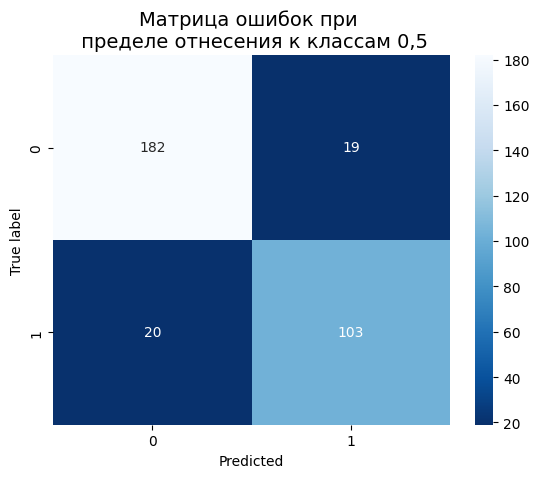

In [102]:
# построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, 
                 annot = True, 
                 fmt = 'd', 
                 cmap = 'Blues_r'
                )
ax.set_title('Матрица ошибок при \n пределе отнесения к классам 0,5', fontsize = 14)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

In [103]:
# Получаем предсказанные вероятности для положительного класса
y_proba = randomized_search.best_estimator_.predict_proba(X_test)[:,1]

In [104]:
# Создаем список порогов от 0,1 до 1
thresholds = [round(i, 4) for i in np.linspace(0.0, 1, num = 500, endpoint = False)]

In [105]:
# Создаем списки для хранения значений recall и accuracy при каждом пороге
threshold_rc_value = []
threshold_ac_value = []

In [106]:
# Вычисляем recall и accuracy для каждого порога и добавляем в списки
for threshold in thresholds:
    y_pred = [1 if x > threshold else 0 for x in y_proba]
    recall = recall_score(y_test, y_pred, zero_division = 0)
    accuracy = accuracy_score(y_test, y_pred)
    
    threshold_rc_value.append(recall)
    threshold_ac_value.append(accuracy)

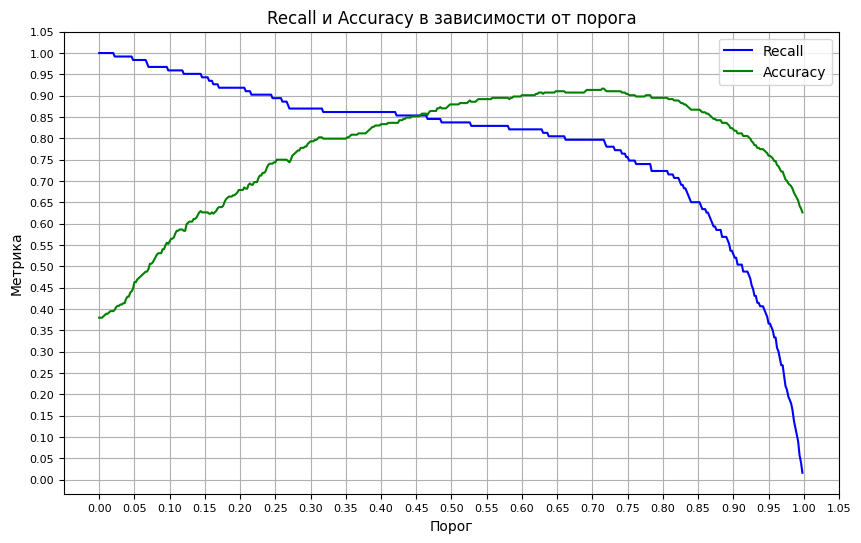

In [107]:
# Построение графика
plt.figure(figsize = (10, 6))
plt.plot(thresholds, threshold_rc_value, label = 'Recall', color = 'blue')
plt.plot(thresholds, threshold_ac_value, label = 'Accuracy', color = 'green')
plt.xlabel('Порог')
plt.ylabel('Метрика')
plt.title('Recall и Accuracy в зависимости от порога')
plt.grid(True)
plt.xticks(np.arange(0.0, 1.1, step = 0.05), size = 8)
plt.yticks(np.arange(0.0, 1.1, step = 0.05), size = 8)
plt.legend()
plt.show()

Визуально можно определить, что для максимальное значение Recall достигается на пороге 0,02 - однако при этом наша модель будет ошибаться в 65 % случаев.\
Рассчитаем метрики и матрицу при пороге в 0,25 - чтобы Recall был больше стандартного:

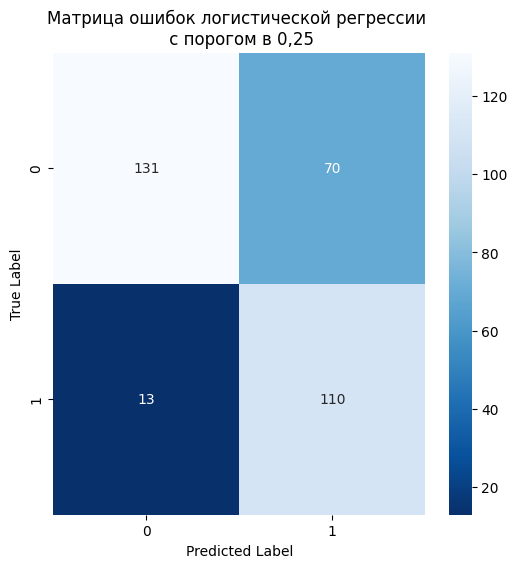

In [108]:
y_precision_max = [1 if x > 0.25 else 0 for x in y_proba]

# Считаем метрики модели
model_set_accuracy = round(accuracy_score(y_test, y_precision_max), 2)
model_set_recall = round(recall_score(y_test, y_precision_max), 2)
model_set_precision = round(precision_score(y_test, y_precision_max), 2)
cm_set = confusion_matrix(y_test, y_precision_max)

# Строим confusion_matrix 
plt.figure(figsize = (6, 6))
sns.heatmap(cm_set, 
            annot = True, 
            cmap = 'Blues_r', 
            fmt = 'd',
            xticklabels = ['0', '1'], 
            yticklabels = ['0', '1'])
plt.title("Матрица ошибок логистической регрессии \n с порогом в 0,25")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [109]:
print(f"Accuracy = {model_set_accuracy}")
print(f"Recall = {model_set_recall}")
print(f"Precision = {model_set_precision}")

Accuracy = 0.74
Recall = 0.89
Precision = 0.61


Ожидаемо, чем больше мы сдвигаем порог вниз - тем огромнее мы получаем ошибку 1-го рода (70 пользователей ошибочно причислены к классу снижения покупательской активности).\
Оставим предел на стандартном значении 0,5.

### ВЫВОД:
На 6 шаге мы перебрали на тестовой выборке модели **KNeighborsClassifier()**, **DecisionTreeClassifier()**, **LogisticRegression()** и **SVC()** используя пайплайны.\
Лучшей моделью по метрике ROC-AUC оказалась **логистическая регрессия** со следующими параметрами:
`C`= **2**\
`class_weight`= **'balanced'**\
`penalty`= **'l1'**\
`solver`= **'liblinear'**\
*Метрика ROC-AUC* на тренировойной выборке: **0.90**

*Метрика ROC-AUC* на тестовой выборке: **0.86**\
*Метрика F1-score* на тестовой выборке: **0.86**\
*Метрика RECALL* на тестовой выборке: **0.84**\
Показатели метрик хорошие, модель хорошо справляется с предсказанием покупательской активности, хотя и 22 раза ошибается - что покупательская активность снизится, хотя это не так, при 103 верных предсказаниях.   

### Шаг 7. Анализ важности признаков 

Оценим важность признаков для лучшей модели и построим график важности, с помощью метода SHAP.

In [110]:
# формируем выборки с лучшими признаками
X_train_new = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test_new = best_model.named_steps['preprocessor'].transform(X_test)

In [111]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_test_new = pd.DataFrame(X_test_new, columns = feature_names)

In [112]:
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_test_new)
shap_values = explainer(X_test_new)

Построим график общей значимости признаков:

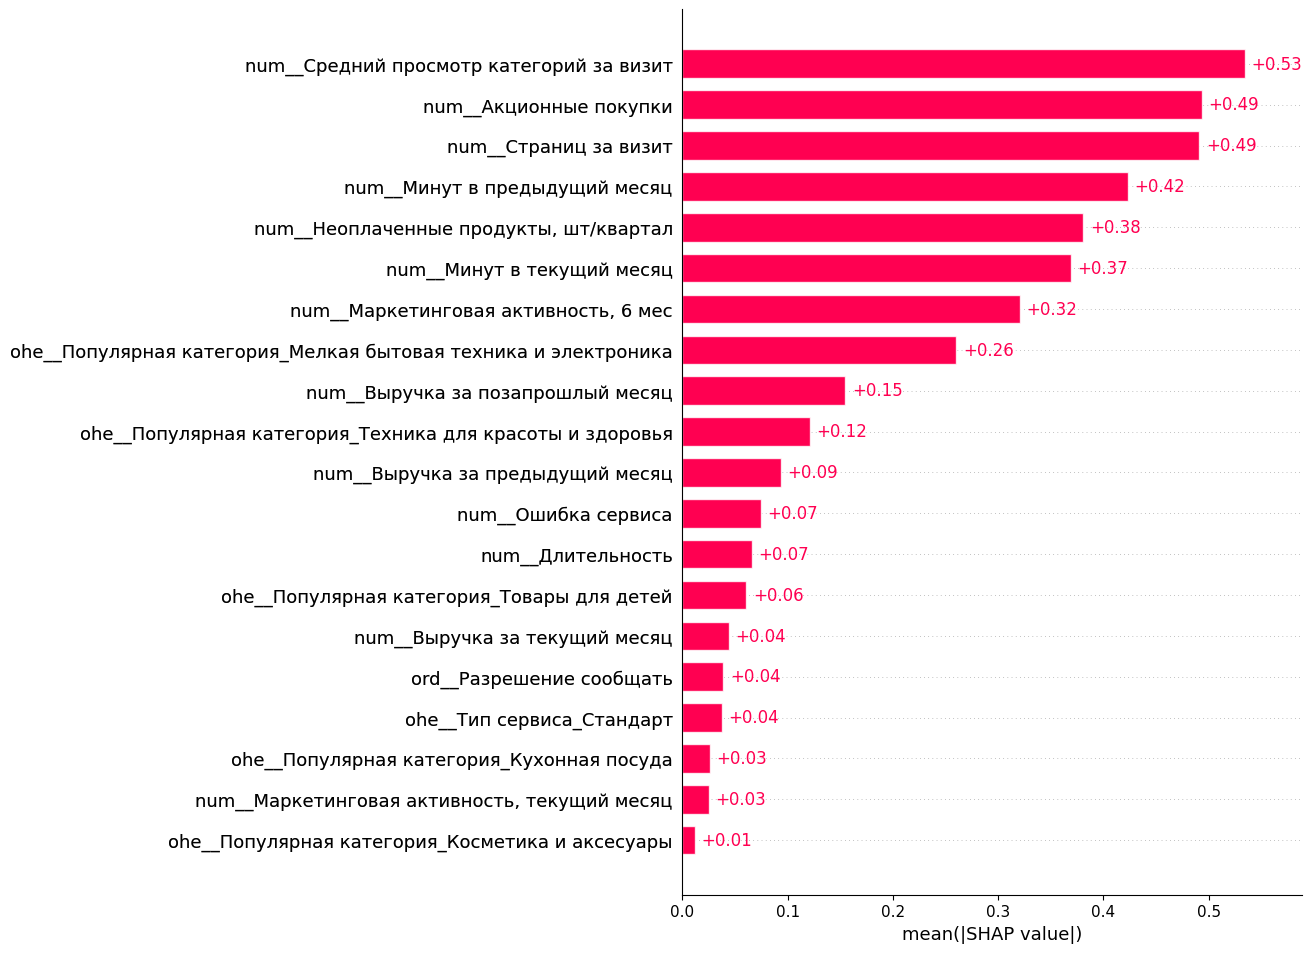

In [135]:
shap.plots.bar(shap_values, max_display = 21)

Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего.\
Посмотрим, как признаки влияют на каждое предсказание модели:

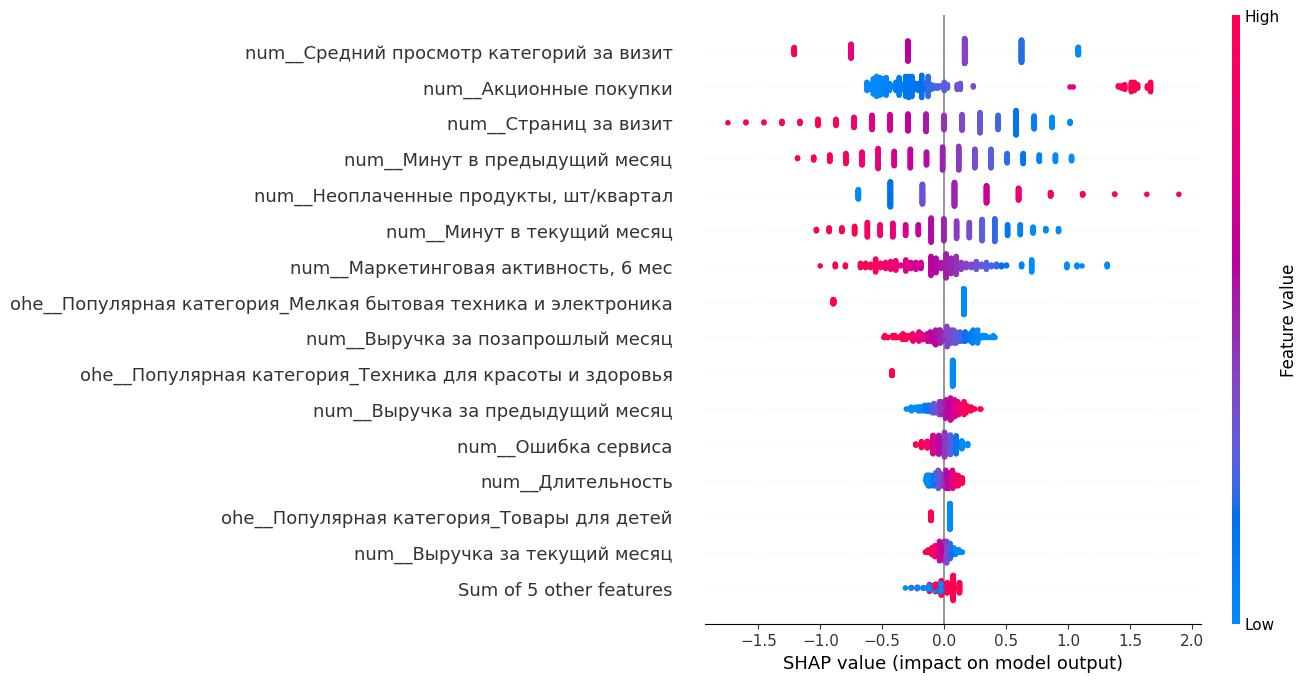

In [114]:
shap.plots.beeswarm(shap_values, max_display = 16)

Высокое значение просмотра страниц за визит снижает вероятность принадлежности пользователя к классу 1 (снижение покупательской активности).\
Так же как, например, параметр - неоплаченные продукты, чем больше неоплаченных продуктов в корзине, тем меньше вероятность снижения покупательской активности, что логично - пользователь ведь собирал себе корзину, потратил время - скорее всего он к ней вернется. 

### ВЫВОД:
Самыми важными признаками для модели оказались: (в порядке убывания)
1. Средний просмотр категорий за визит,
2. Акционные покупки,
3. Страниц за визит,
4. Минут в предыдущий месяц,
5. Неоплаченные продукты, шт/квартал, 
6. Минут в текущий месяц
7. Маркетинговая активность, 6 мес.

И действительно, это легко понять - витрина категорий обычно расположена на главной страницу магазинов - соответственно чем дальше ты уходишь вглубь категорий - тем больше ты смотришь страниц товара и естественно это всё стимулирует тебя на покупку. \
Акционные покупки так же играют важную роль, так как скидка на товар помогает пользователям решиться на покупку(добавить в корзину/отложить на потом).\
То же и относится к количеству просмотренных страниц за визит - чем больше страниц смотрим, тем сильнее разгоняется желание что-либо купить или способствует найти именно тот товар, который пользователь хотел приобрести. \
Так же сложно переоценить влияние времени, проведенного за скроллингом в предыдущий месяц - возможно пользователи щательно выбирают товар и откладывают покупки до ЗП.\
Неоплаченные покупки - это как копилка, то, что не можешь купить сейчас, но оно уже висит в корзине и напоминает о себе - обязательная вещь для стимулирования пользователей - могут быть тесно связаны с маркетинговой акивностью, так как именно в корзине легче всего отследить скидки на тот товар, который точно понравился пользователю, но у него пока нет возможности (или настоящего желания) его приобрести. 

Как и ТОР-6 признак: минут в текущий месяц, важный параметр в общем смысле, ведь если пользователь в текущий период заходит на наш маркет (а например не ушел на площадку к конкурентам), значит всё в наших руках - мы должны разогнать покупательскую активность нашего пользователя. 

Маловажными признаками оказались: (в порядке позрастания)\
21. Популярная категория_косметика и аксессуары,\
20. Маркетинговая активность за текущий месяц,\
19. Популярная категория_Кухонная посуда. 

Эти признаки говорят нам о том, что категории косметики и посуды не оказывают существенного влияния на покупательскую активность пользователей, так же как и маркетинговая активность на текущий месяц, т.к. не все пользователи могут себе позволить покупать "сдесь и сейчас" - поэтому в маркетинг нужно работать вдолгую, видим эффективность его работы на дистанции.  


Для безнес-решений нам необходимо, чтобы пользователь как можно дольше был сфокусирован на скроллинге страниц, что то обязательно его зацепит, поспособствовать этому могут всплывающие категории схожих товаров. Необходимо, чтобы пользователь пополнял свою корзину и хотел вернуться и продолжить покупки.

### Шаг 8. Сегментация покупателей
Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.

In [115]:
df_market = df_market_full.copy()
df_market = df_market.drop('Покупательская активность', axis = 1)
# Инициализируем лучшую модель:
best_model = randomized_search.best_estimator_

Cоберем данные для анализа в общий датафрейм:

In [116]:
# Добавляем столбец с вероятностями отнесения к классу 1 (снижение покупательской активности)
df_market['Вероятность снижения активности'] = best_model.predict_proba(df_market)[:, 1]

In [117]:
# Добавляем столбец с прогнозами лучшей модели
df_market['Прогноз модели'] = best_model.predict(df_market)

In [118]:
# Объединяем датасет с информацией о прибыли
df_market = df_market.merge(df_money, on = 'id')

In [119]:
df_market.head(5)

,id,Тип сервиса,Разрешение сообщать,"Маркетинговая активность, 6 мес","Маркетинговая активность, текущий месяц",Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,"Неоплаченные продукты, шт/квартал",Ошибка сервиса,Страниц за визит,Выручка за позапрошлый месяц,Выручка за предыдущий месяц,Выручка за текущий месяц,Минут в предыдущий месяц,Минут в текущий месяц,Вероятность снижения активности,Прогноз модели,Прибыль
0,215349,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0,0.913536,1,4.16
1,215350,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0,0.420420,0,3.13
2,215351,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0,0.855282,1,4.87
3,215352,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0,0.964477,1,4.21
4,215353,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10.0,10.0,0.718345,1,3.95


Так как нас интересуют данные о прибыльности покупателей - построим зависимость прибыльности от вероятности снижения покупательской активности, с выделением целевого и дополнительного сегмента:

Целевой сегмент - с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью - так как он больше всего интересен бизнесу. (Напомню, средняя прибыль у нас - 4 единицы, будем считать прибыль выше среднего - высокой.)

In [120]:
# Делаем срез по целевому сегменту
top_segment = df_market.query('`Вероятность снижения активности` > 0.8 and Прибыль > 4') 

Для сравнения возьмем сегмент, который имеет вероятность от до 0,2 - так сказать идеальные пользователи с высокой покупательской активностью и прибылью.

In [121]:
# Делаем срез по дополнительному сегменту
dop_segment = df_market.query('0 < `Вероятность снижения активности` < 0.2 and Прибыль > 4') 

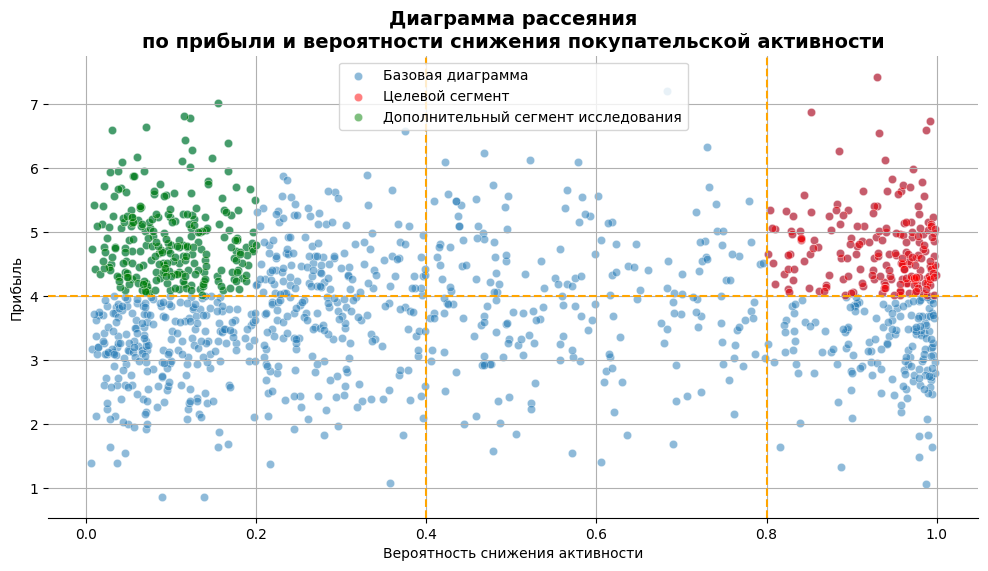

In [122]:
# Строим диаграмму рассеяния по сегментам
plt.figure(figsize = (12, 6))
sns.scatterplot(
    data = df_market,
    x ='Вероятность снижения активности',
    y ='Прибыль',
    alpha = 0.5,
    label = 'Базовая диаграмма'
    
)
sns.scatterplot(
    data = top_segment,
    x ='Вероятность снижения активности',
    y ='Прибыль',
    alpha = 0.5,
    color = 'red',
    label = 'Целевой сегмент'
)
sns.scatterplot(
    data = dop_segment,
    x ='Вероятность снижения активности',
    y ='Прибыль',
    alpha = 0.5,
    color = 'green',
    label = 'Дополнительный сегмент исследования'
)
plt.title(
    'Диаграмма рассеяния\nпо прибыли и вероятности снижения покупательской активности',
    fontsize = 14,
    fontweight = 'bold'
)
plt.legend()
plt.axvline(x = 0.8, color = 'orange', linestyle = '--')
plt.axvline(x = 0.4, color = 'orange', linestyle = '--')
plt.axhline(y = 4, color = 'orange', linestyle = '--')
sns.despine(left = True)
plt.grid(True)
plt.show()

Добавим в общий датасет принадлежность наших пользователей к выбранным сегментам:

In [123]:
df_market['Сегмент'] = df_market.apply(lambda row: 'Целевой сегмент' 
    if row['Вероятность снижения активности'] > 0.8 and row['Прибыль'] > 4
    else ('Идеальный сегмент' 
          if 0 < row['Вероятность снижения активности'] < 0.2 and row['Прибыль'] > 4
          else 'Остальные пользователи'), axis = 1)

Теперь посмотрим на наши сегменты в разрезе выделенных нами важных признаков: 

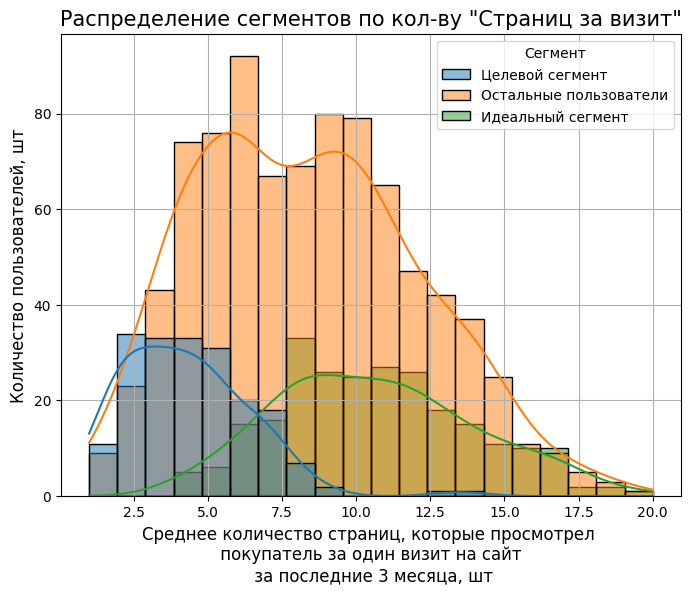

In [124]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 20, kde = True, hue = 'Сегмент', x = 'Страниц за визит')
plt.title('Распределение сегментов по кол-ву "Страниц за визит"', size = 15)
plt.xlabel('Среднее количество страниц, которые просмотрел \n покупатель за один визит на сайт \n за последние 3 месяца, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

По полученной гистограмме - можем отметить, что большинство пользователей целевого сегмента скроллят ленту неактивно, тем самым пропускают мимо себя огромный ассортимент смежных товаров. И это те пользователи - которые приносят большую прибыль компании ! \
Целевому сегменту необходимо подтягивать просмотры страниц к значениям идеального сегмента ! 

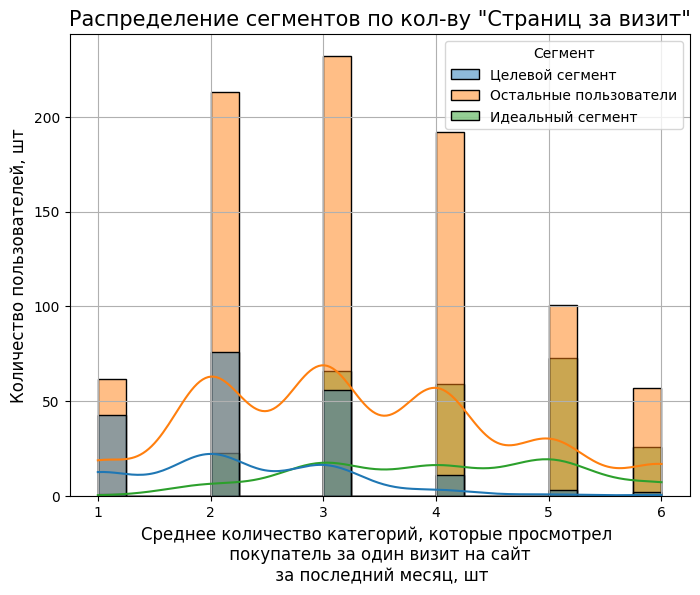

In [125]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 20, kde = True, hue = 'Сегмент', x = 'Средний просмотр категорий за визит')
plt.title('Распределение сегментов по кол-ву "Страниц за визит"', size = 15)
plt.xlabel('Среднее количество категорий, которые просмотрел \n покупатель за один визит на сайт \n за последний месяц, шт', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Видим как наши категории взаимосвязаны - мало просматриваешь карточек товара - следовательно и счетчик категорий у тебя на минимуме (1 - 2 категории). Необходимо подтягивать показатели выделенных сегментов до идеальных пользователей. 

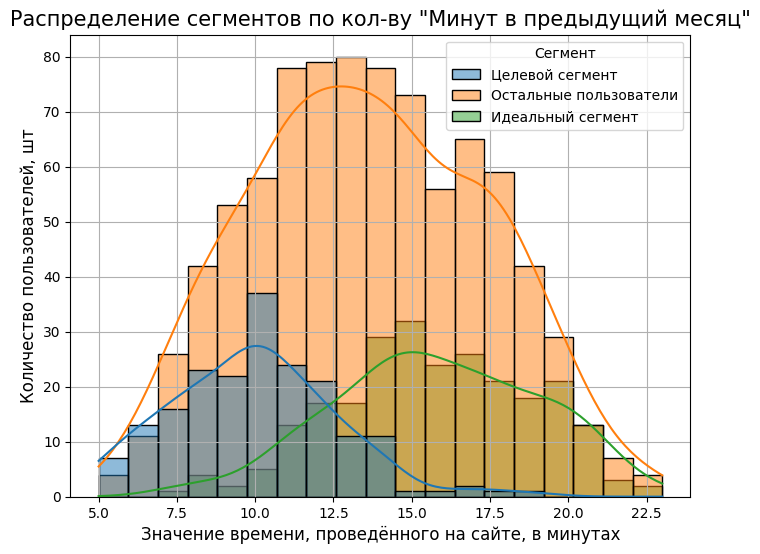

In [126]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 19, kde = True, hue = 'Сегмент', x = 'Минут в предыдущий месяц')
plt.title('Распределение сегментов по кол-ву "Минут в предыдущий месяц"', size = 15)
plt.xlabel('Значение времени, проведённого на сайте, в минутах', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Пользователи целевого сегмента, в среднем проводят на сайте 10 минут - необходимо увеличивать это время до 17,5 минут.

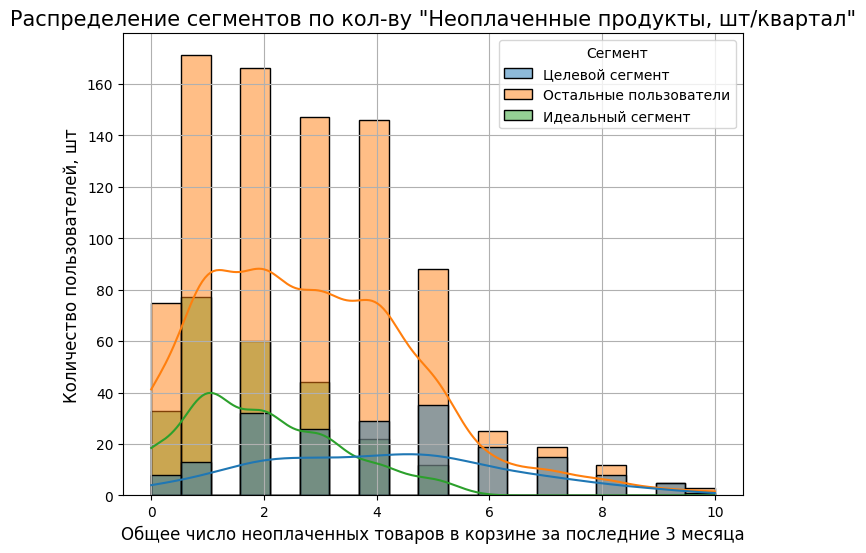

In [127]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 19, kde = True, hue = 'Сегмент', x = 'Неоплаченные продукты, шт/квартал')
plt.title('Распределение сегментов по кол-ву "Неоплаченные продукты, шт/квартал"', size = 15)
plt.xlabel('Общее число неоплаченных товаров в корзине за последние 3 месяца', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Снижение покупательской активности подразумевает, что у пользователя копятся товары в корзине (и наоборот), как видно выше - у хороших пользователей в среднем 3 товара не оплачено, тогда как у целевого сегмента этот показатель равен 5. Однако, по моему мнению, наличие большего количества товаров в корзине рано или поздно подталкнет пользователя к покупке - ведь он старательно выбирал эти товары, просто вопрос цены его не устраивает. 


Может нам необходимо ввести механизм, который будет регулировать ценообразование и предлагать бОльшие скидки, если товар уже в корзине пользователя - дольше определенной временной границы. 

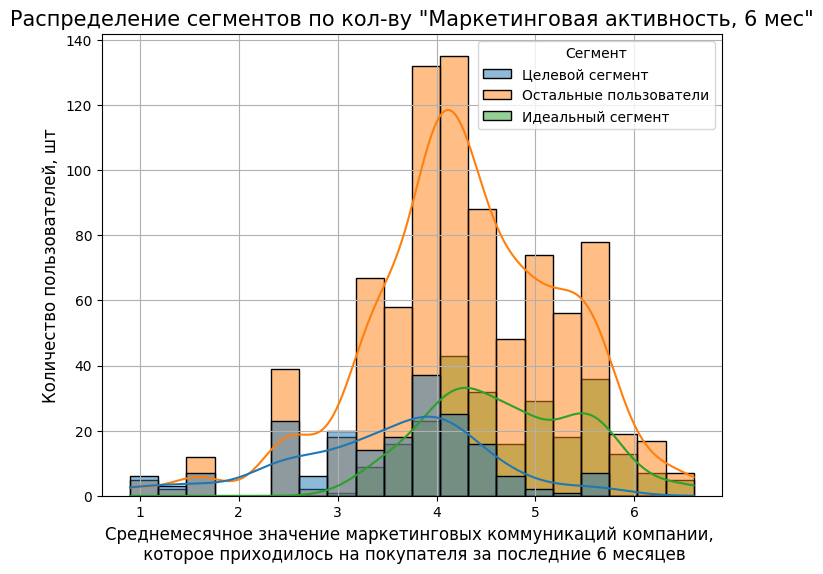

In [128]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 20, kde = True, hue = 'Сегмент', x = 'Маркетинговая активность, 6 мес')
plt.title('Распределение сегментов по кол-ву "Маркетинговая активность, 6 мес"', size = 15)
plt.xlabel('Среднемесячное значение маркетинговых коммуникаций компании, \n которое приходилось на покупателя за последние 6 месяцев', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Для стимулирования покупательской активности необходимо увеличивать маркетинговое воздействие на целевой сегмент.

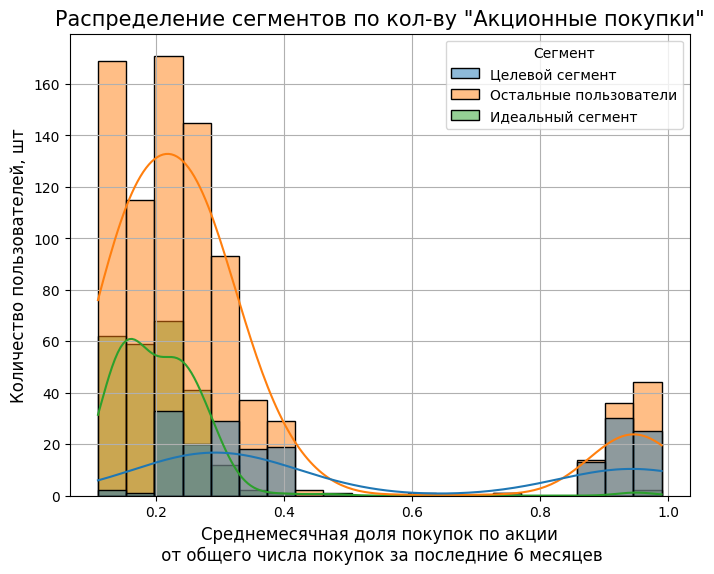

In [129]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 20, kde = True, hue = 'Сегмент', x = 'Акционные покупки')
plt.title('Распределение сегментов по кол-ву "Акционные покупки"', size = 15)
plt.xlabel('Среднемесячная доля покупок по акции\n от общего числа покупок за последние 6 месяцев', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.grid(True)
plt.show()

Как видно выше - идеальных клиентов не интересуют акционные товары, видимо у них всё в порядке с финансовым благополучием, тогда как целевой сегмент почти одинаково представлен среди тех - кто охотится за акциями и тех, кто их игнорирует. \
Наличие акционных предложений не всегда направлено на пользу клиента - иногда банально надо освободить площади и распродать остатки для закупа нового товара.

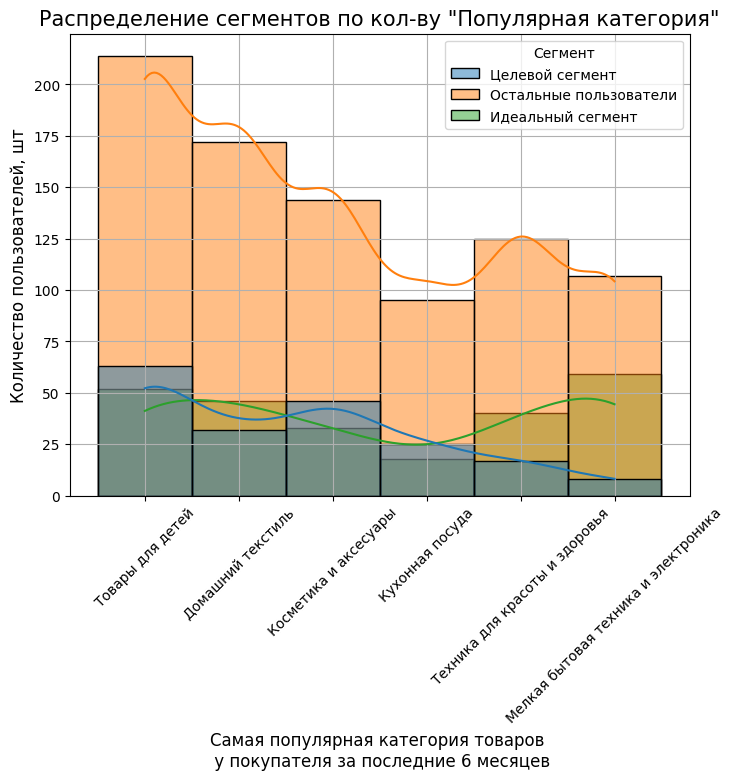

In [130]:
plt.figure(figsize=(8,6))
plot = sns.histplot(df_market, bins = 20, kde = True, hue = 'Сегмент', x = 'Популярная категория')
plt.title('Распределение сегментов по кол-ву "Популярная категория"', size = 15)
plt.xlabel('Самая популярная категория товаров \n у покупателя за последние 6 месяцев', size = 12)
plt.ylabel('Количество пользователей, шт', size = 12)
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

Самой популярной категорией товаров у целевого сегмента являются `"Товары для детей"`, тогда как меньше всего они интересуются `"Бытовой техникой"`.\
Напротив, идеальный сегмент - больше всего интересуется `"Бытовой техникой"`, `"Текстилем"`. \
Напрашивается вывод, что покупательская активность падает с появлением детей, так как финансы уходят на необходимые детям товары, а не на "хотелки" для души. 

### Шаг 9 - ИТОГОВЫЙ ВЫВОД:
В данном исследовании перед нами стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**ШАГ 1 - Загрузка данных**\
В нашем распоряжении датафреймы:
- `df_market_file` на **13** колонок и **1300** строк;
- `df_market_money` на **3** колонки и **3900** строк;
- `df_market_time` на **3** колонки и **2600** строк;
- `df_money` на **2** колонки и **1300** строк.
Пропуски в данных не обнаружены.\
Для корректного исследования необходимо предобработать данные, а именно:
- привести названия столбцов к общему стилю;
- преобразовать значения в столбце `Период` к общему стилю;
- проверить датафреймы на явные/неявные дубликаты.

**ШАГ 2 - Предобработка данных**\
На этапе предобработки данных, мы:
- привели названия столбцов и содержимое датафреймов к общему стилю;
- устранили орфографическую ошибку в столбце `Период` датафрейма `df_market_time`;\
Провели проверку на явные/неявные дубликаты:
- устранили неявные дубликаты в столбце `Тип сервиса` датафрейма `df_market_file`, в остальных данных дубликаты отсутствуют.

**ШАГ 3 - Исследовательский анализ данных**\
На этапе исследовательского анализа данных мы выяснили: 
1. `Покупательская активность` снижена в 38,3 % случаев.

2. Большинство пользователей пользуются *стандартным тарифом*, однако в долевом соотношении - покупательская активность снизилась больше у премиум пользователей
3. Большинство пользователей `согласны` получать *дополнительные предложения* о товарах, однако именно у таких пользователей и наблюдается большее снижение покупательской активности.
4. Наибольшей популярностью пользуются товары для детей, в то время как кухонная посуда занимает последнее место.

- При изучении суммарной выручки были обнаружены и удалены пользователи с нулевой выручкой, т.к. они не интересны нашей компании, а так же удалено аномально высокое значение выручки. Распределение выручки характеризуется *нормальным* типом. \
Так же отбраны 1296 клиентов с покупательской активностью не менее трёх месяцев.

- Время, проведенное на сайте - характеризуется нормальным распределением и в среднем занимает 13 минут.

- Прибыль продавца от продаж каждому покупателю - характеризуется нормальным распределением и в среднем составляет 4 условные единицы.

**ШАГ 4 - Объединение таблиц**\
Данные из датафреймов `df_market_file`, `df_market_money` и `df_market_time` объединены в одну таблицу.\
Перед этим выполнено разделение времени и выручки по перодам. \
В итоговом датасете получили **18** столбцов и **1296** ненулевых строк. 

**ШАГ 5 - Корреляционный анализ**\
В ходе корреляционного анализа мы обнаружили, что мультиколлинеарность отсутствует, т.к. ни один из параметров не коррелирует с коэффициентом 1. \
Посмотрим на выделяющиеся значения коэффициентов нашего целевого признака:  
1. **`Покупательская активность`**:
   - **Сильные корреляции**:
     - Прослеживается сильная положительная корреляция со `Страниц за визит` **(0,75)** и `Минут в предыдущий месяц` **(0,69)**. Следовательно, покупательская активность сильно зависит от количества просмотренных страниц на сайте, а так же от суммарного времени просмотра в предыдущий месяц. Это может говорить о том, что пользователи заранее планируют свои покупки и тщательно их выбирают. 
   - **Умеренные корреляции**:
     - Умеренная положительная корреляция с `Маркетинговая активность, 6 мес` **(0,54)**, `Акционные покупки` **(0,51)**, `Средний просмотр категорий за визит` **(0,54)**, `Неоплаенные продукты, шт/квартал` **(0,51)**, `Выручка за позапрошлый месяц` **(0,5)**, `Минут в текущий месяц` **(0,58)** показывает нам, что все эти параметры умеренно влияют на покупательскую активность, за исключением `выручки` - т.к. это покупательская активность влияет на выручку.\
     К примеру - у пользователя есть неоплаченные покупки в корзине, он серфит наш маркет каждый день проверяя - не появилась ли акция на его товары, смотрит разные категории и может что то отложить на покупку в следующем месяце(отложить до зарплаты) - вот так и проявляется наша взаимосвязь параметров.

**ШАГ 6 - Использование пайплайнов**\
На 6 шаге мы перебрали на тестовой выборке модели **KNeighborsClassifier()**, **DecisionTreeClassifier()**, **LogisticRegression()** и **SVC()** используя пайплайны.\
Лучшей моделью по метрике ROC-AUC оказалась **логистическая регрессия** со следующими параметрами:
`C`= **2**\
`class_weight`= **'balanced'**\
`penalty`= **'l1'**\
`solver`= **'liblinear'**\
*Метрика ROC-AUC* на тренировойной выборке: **0.90**

*Метрика ROC-AUC* на тестовой выборке: **0.86**\
*Метрика F1-score* на тестовой выборке: **0.86**\
*Метрика RECALL* на тестовой выборке: **0.84**\
Показатели метрик хорошие, модель хорошо справляется с предсказанием покупательской активности, хотя и 22 раза ошибается - что покупательская активность снизится, хотя это не так, при 103 верных предсказаниях.  

**ШАГ 7 - Анализ важности признаков**\
Самыми важными признаками для модели оказались: (в порядке убывания)
1. Средний просмотр категорий за визит,
2. Акционные покупки,
3. Страниц за визит,
4. Минут в предыдущий месяц,
5. Неоплаченные продукты, шт/квартал, 
6. Минут в текущий месяц
7. Маркетинговая активность, 6 мес.

Маловажными признаками оказались: (в порядке позрастания)\
21. Популярная категория_косметика и аксессуары,\
20. Маркетинговая активность за текущий месяц,\
19. Популярная категория_Кухонная посуда. 

**ШАГ 8 - Сегментация покупателей**\
Используя данные модели и данные о прибыльности клиентов, мы выделили сегменты покупателей, которые имеют высокую вероятность снижения покупательской активности, а так же приносят компании высокую прибыль. Так же для сравнения мы выделили "идеальный" сегмент, который, принося высокую прибыль - имеет наименькую вероятность снижения покупательской способности. 

**ШАГ 9 - Итоговые рекомендации бизнесу**\
Мы сделали предположение, что целевой сегмент - это пользователи с детьми, которые больше всего времени уделяют товарам для детей, мало скроллят карточки товаров и не заглядфвают по разным категориям. \
Тогда как "идеальный" сегмент - это люди, у которых ещё нет детей, либо они уже выросли - у таких пользователей есть время на тщательный просмотр продуктов, категорий и т.д. 

Подводя итог к выше сказанному, рекомендую бизнесу сделать упор на **товары для детей** - необходимо заставить пользователей смотреть **большее количество категорий товаров** - это может разогнать желание что-либо купить или поспособствует найти качественный товар, который пользователь хотел приобрести.

То же и относится к акционным покупкам - хорошая скидка всегда даст мотивацию на покупку. \
**Раздел с детскими категориями товаров необходимо поднимать в самый верх.** \
Неоплаченные покупки - это как копилка, то, что не можешь купить сейчас, но оно уже висит в корзине и напоминает о себе - обязательная вещь для стимулирования пользователей - могут быть тесно связаны с маркетинговой акивностью, так как именно в корзине легче всего отследить скидки на тот товар, который точно понравился пользователю, но у него пока нет возможности (или настоящего желания) его приобрести.

Возможно, нам необходимо ввести **механизм**, который будет регулировать ценообразование и предлагать бОльшие скидки, если товар уже в корзине пользователя - дольше определенной временной границы. 